In [2]:
import sys
import os.path as op
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
import nibabel as nib

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm

sys.path.append(op.join(op.expanduser("~"), "code", "style"))
from colors import get_colors
co, palettes = get_colors()

sys.path.append(op.join(op.expanduser("~"), "code"))
from general.array import array_operations as aop
from general.basic.helper_funcs import *
import general.nifti.nifti_ops as nops

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
mpl.rcParams['font.sans-serif'] = "Helvetica"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["xtick.major.width"] = 0.8
mpl.rcParams["ytick.major.width"] = 0.8
colors = [
    "1f77b4",
    "d62728",
    "2ca02c",
    "ff7f0e",
    "9467bd",
    "8c564b",
    "e377c2",
    "7f7f7f",
    "bcbd22",
    "17becf",
]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelpad"] = 8
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["legend.loc"] = "upper right"
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.titlesize"] = 16
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.subplot.wspace"] = 0.25
mpl.rcParams["figure.subplot.hspace"] = 0.25
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["pdf.fonttype"] = 42
font = {"tick": 6, "label": 7, "title": 8}
colws = {1: 2.05, 2: 3.125, 3: 6.45}

In [3]:
# Load subject demographic data.
overwrite = False
save_output = True
proj_dir = op.join(op.expanduser("~"), "Box", "projects", "leads_tau_spread")
data_dir = op.join(proj_dir, "data")

# ----------------------------
infile = op.join(data_dir, "ssheets", "tau_rois_spec.csv")
tau_suvrs = pd.read_csv(infile, index_col=0)
tau_suvrs = tau_suvrs.rename(columns={
    # "region": "roi",
    "years_from_baseline_pet": "years_from_bline",
    "cdrsob_baseline": "cdrsb_bline",
    })
tau_suvrs.insert(1, "subjroi", tau_suvrs.apply(lambda x: f"{x.subj}_{x.roi}", axis=1))
tau_suvrs.insert(10, "cdrsbgt4", tau_suvrs["cdrsb_bline"] > 4)
tau_suvrs.loc[tau_suvrs["cdrsb_bline"]==-999, "cdrsbgt4"] = -999

# Select only EOAD subjects.
tau_suvrs = tau_suvrs.query("(dx=='EOAD')")
tau_suvrs_bline = tau_suvrs.query("(visit==1)").set_index(["subj", "roi"])
tau_suvrs_long = tau_suvrs.query("(visit>1)").copy()
tau_suvrs_long["bline_suvr"] = tau_suvrs_long.apply(lambda x: tau_suvrs_bline.at[(x["subj"], x["roi"]), "value"], axis=1)
tau_suvrs_long["delta_suvr"] = tau_suvrs_long.apply(lambda x: x["value"] - x["bline_suvr"], axis=1)

# Save the data.
outfile = op.join(data_dir, "ssheets", "tau_roi_suvrs_eoad_long.csv")
if save_output and (overwrite or not op.isfile(outfile)):
    tau_suvrs_long.to_csv(outfile)
    print("Saved: {}".format(outfile))

print(f"Number of subjects: {tau_suvrs_long['subj'].nunique()}")
print(f"Number of regions: {tau_suvrs_long['roi'].nunique()}")
print(f"tau_suvrs.shape: {tau_suvrs.shape}",
      "tau_suvrs.shape (Ss with 2+ visits): {}".format(tau_suvrs.query("(pet_visits>1)").shape),
      f"tau_suvrs_long.shape: {tau_suvrs_long.shape}",
      "No. subjects with >=1 timepoint: {}, >=2 timepoints: {}, >=3 timepoints: {}".format(
          tau_suvrs.query("pet_visits>=1")["subj"].nunique(),
          tau_suvrs.query("pet_visits>=2")["subj"].nunique(),
          tau_suvrs.query("pet_visits>=3")["subj"].nunique(),
          ),
      sep="\n")

Number of subjects: 126
Number of regions: 16
tau_suvrs.shape: (7168, 27)
tau_suvrs.shape (Ss with 2+ visits): (4752, 27)
tau_suvrs_long.shape: (2736, 29)
No. subjects with >=1 timepoint: 277, >=2 timepoints: 126, >=3 timepoints: 37


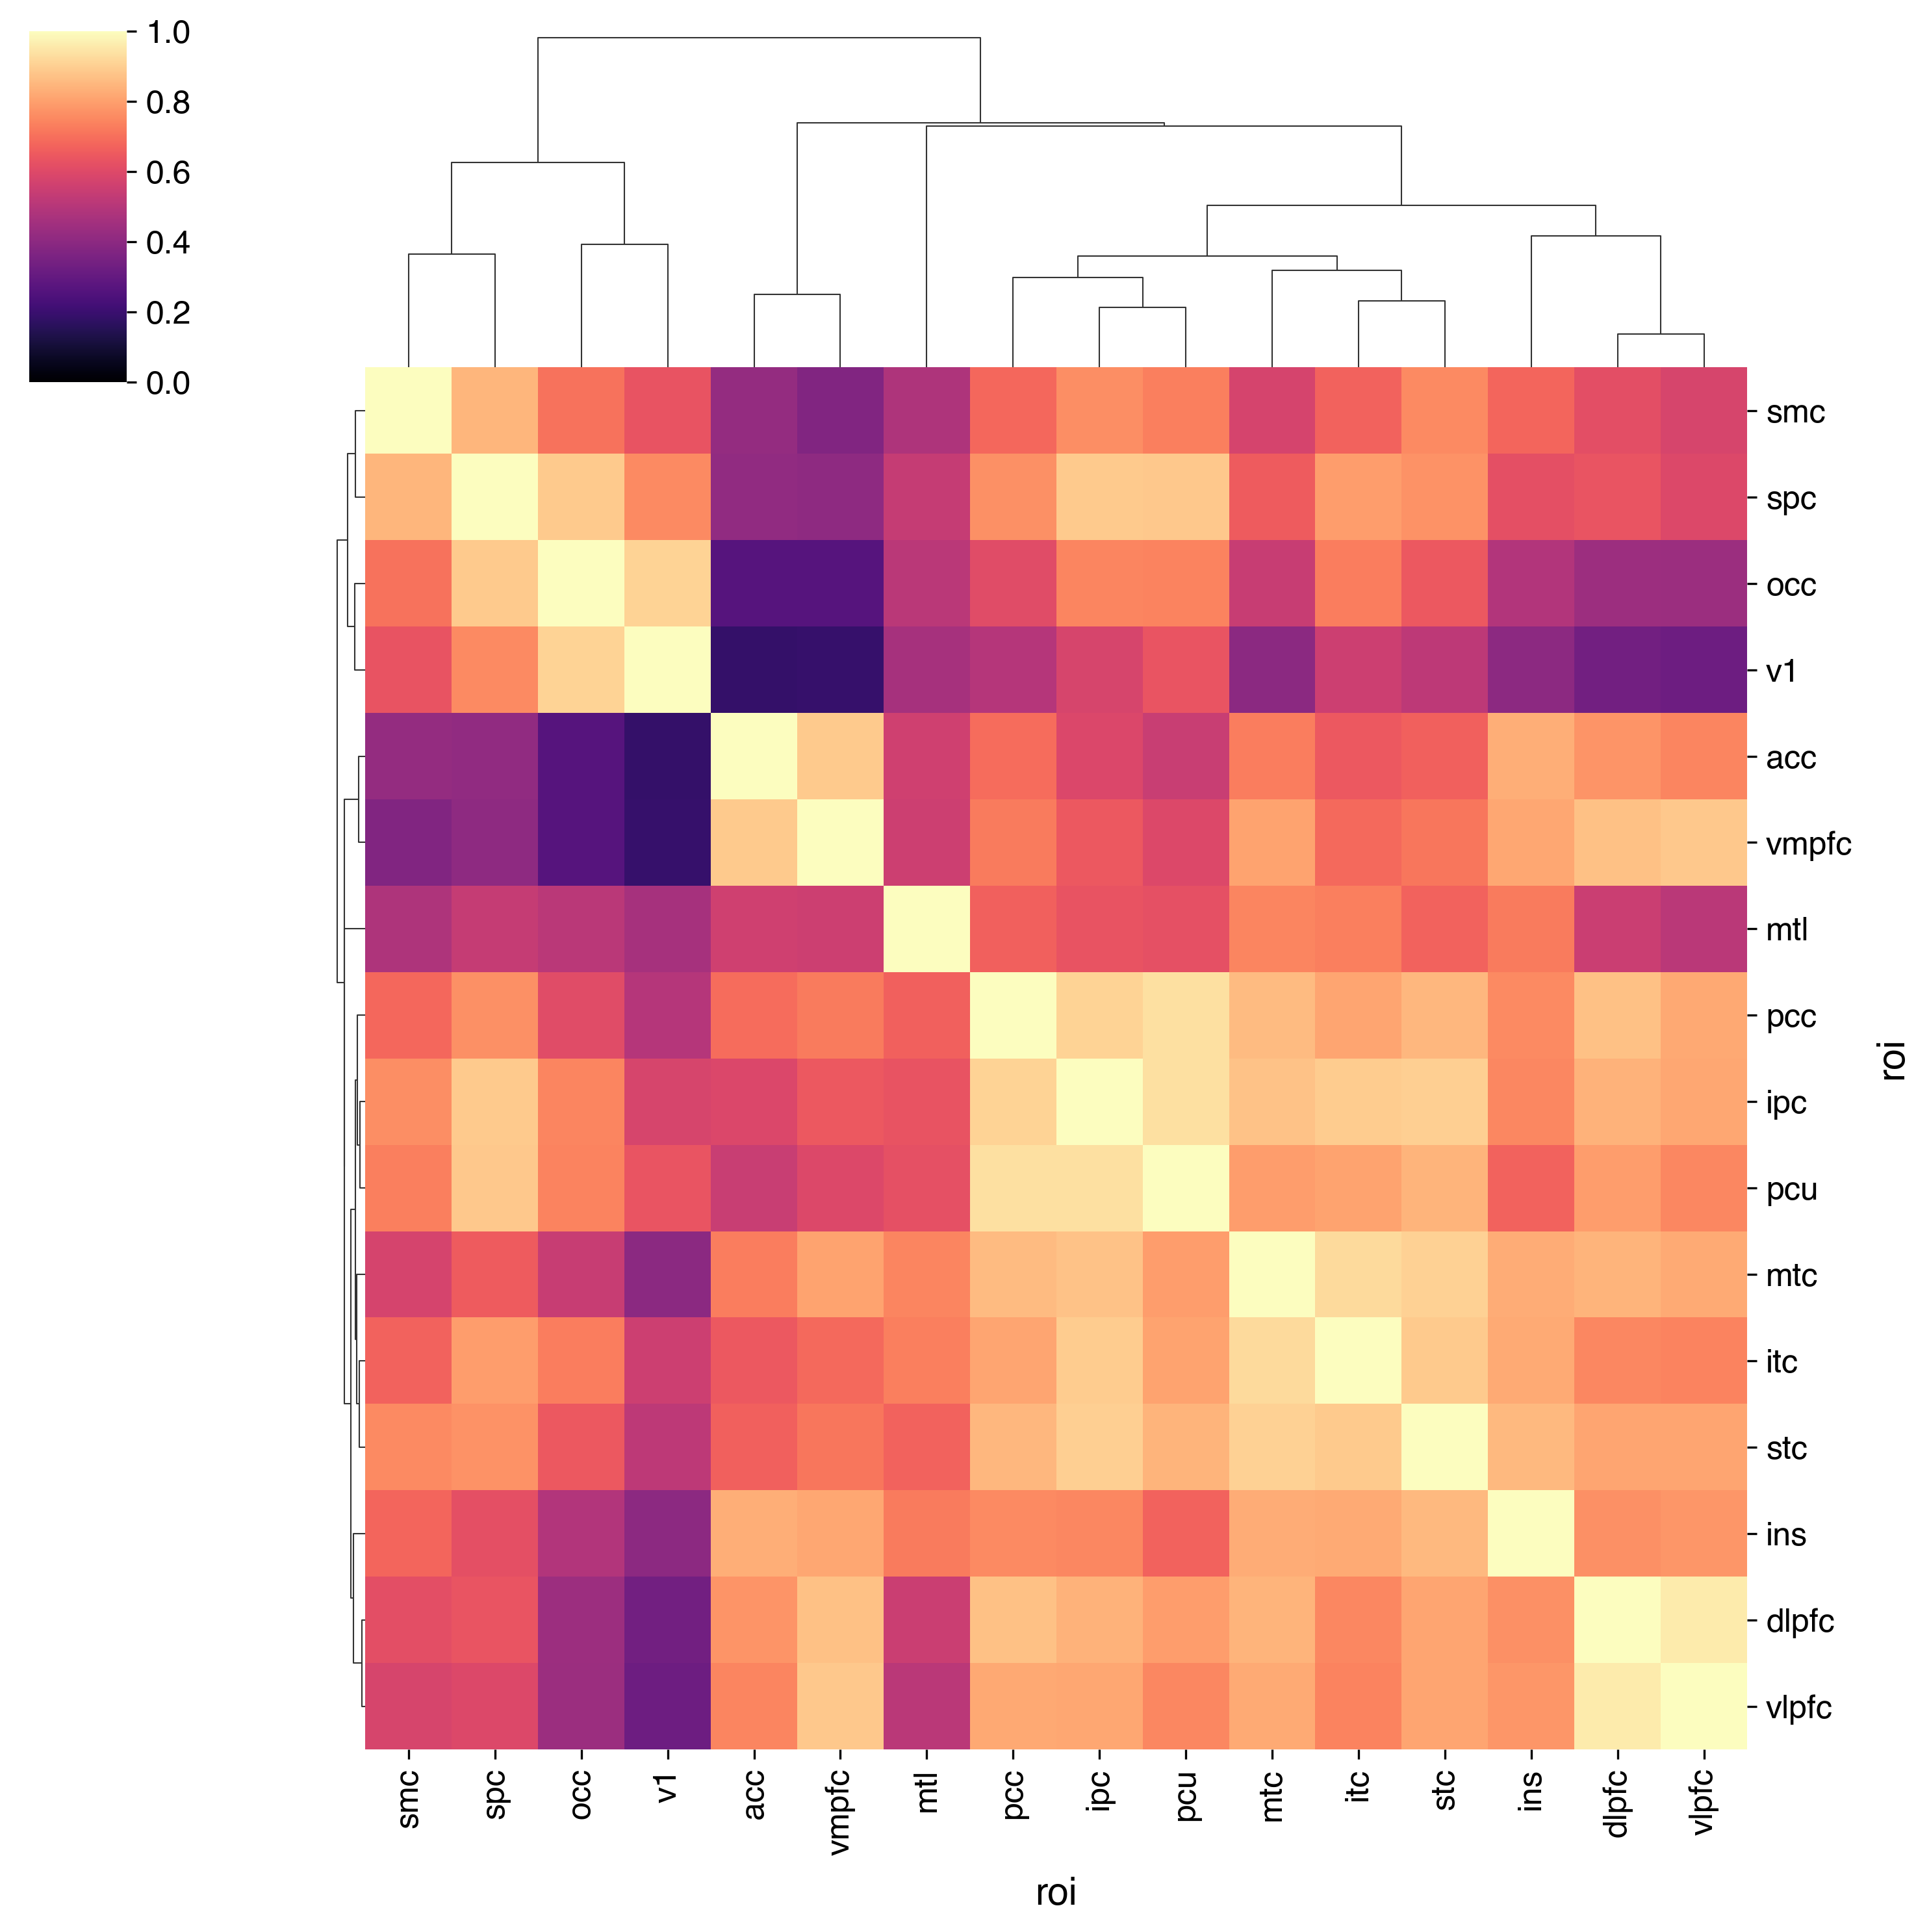

In [405]:
# Correlate SUVRs in each region, across EOAD subjects at baseline.
keep_cols = ["subj", "roi", "value"]
bline_suvrs = tau_suvrs.query("visit==1")[keep_cols].set_index(["subj", "roi"]).unstack().copy()
bline_suvrs.columns = bline_suvrs.columns.droplevel(0)
mat = bline_suvrs.corr()
mask = None#mat[:, 1:]<2
vmin = 0
vmax = 1
cbar_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
cmap = "magma"
cbar_label = "Pearson r"
grid_shp = [50, 55]
figsize = (colws[3], colws[3] * (grid_shp[0] / grid_shp[1]))
dpi = 600
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
nsubjs = mat.shape[0]
xticks = np.arange(len(mat.columns)) + 0.5
xticklabs = [x.replace('_', ' ') for x in mat.columns]
yticks = np.arange(len(mat.index)) + 0.5
yticklabs = [x.replace('_', ' ') for x in mat.index]
background_color = co["x1"]
do_cluster = True
savefig = 0
overwrite = 1

# ----------------------------------------------------------------------
plt.close("all")
if do_cluster:
    cg = sns.clustermap(
        mat,
        mask=mask,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        figsize=(10, 10)
    )
    cg.ax_row_dendrogram.set_xticks(np.arange(mat.shape[1]))
    cg.ax_row_dendrogram.set_yticks(np.arange(mat.shape[1]))
else:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = [
        plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
        plt.subplot2grid(grid_shp, (0, 52), rowspan=50, colspan=3),
    ]
    iax = 0
    _ax = ax[iax]
    _ax = sns.heatmap(
        mat,
        mask=mask,
        vmin=vmin,
        vmax=vmax,
        ax=_ax,
        cbar_ax=ax[iax + 1],
        cmap=cmap,
        square=True
    )
    cbar = _ax.collections[0].colorbar
    cbar.ax.tick_params(
        labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
    )
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font["label"], labelpad=labelpad)
    _ax.set_facecolor(background_color)
    _ax.tick_params(
        axis="x", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad, rotation=90
    )
    _ax.tick_params(
        axis="y", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad
    )
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticklabs)
    _ax.set_xlabel("")
    _ax.set_ylabel("")

if savefig:
    filename = op.join(
        fig_dir,
        "FTP_ROI_W-scores_{}_Visit{}_{}subjs2.png".format(
            dx, str(visit).replace(" ", ""), nsubjs
        ),
    )
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches="tight", pad_inches=0)
        fig.savefig(filename.replace(".png", ".pdf"), bbox_inches="tight", pad_inches=0)
        print("Saved {}".format(filename))

In [ ]:
# Correlate SUVRs in each region, across EOAD subjects at baseline.
keep_cols = ["subj", "roi", "value"]
bline_suvrs = tau_suvrs.query("visit==1")[keep_cols].set_index(["subj", "roi"]).unstack().copy()
bline_suvrs.columns = bline_suvrs.columns.droplevel(0)
mat = bline_suvrs.corr()
mask = None#mat[:, 1:]<2
vmin = 0
vmax = 1
cbar_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
cmap = "magma"
cbar_label = "Pearson r"
grid_shp = [50, 55]
figsize = (colws[3], colws[3] * (grid_shp[0] / grid_shp[1]))
dpi = 600
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
nsubjs = mat.shape[0]
xticks = np.arange(len(mat.columns)) + 0.5
xticklabs = [x.replace('_', ' ') for x in mat.columns]
yticks = np.arange(len(mat.index)) + 0.5
yticklabs = [x.replace('_', ' ') for x in mat.index]
background_color = co["x1"]
do_cluster = True
savefig = 0
overwrite = 1

# ----------------------------------------------------------------------
plt.close("all")
if do_cluster:
    cg = sns.clustermap(
        mat,
        mask=mask,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        cbar=False,
        figsize=(25, 25)
    )
    cg.ax_row_dendrogram.set_xticks(np.arange(mat.shape[1]))
    cg.ax_row_dendrogram.set_yticks(np.arange(mat.shape[1]))
else:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = [
        plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
        plt.subplot2grid(grid_shp, (0, 52), rowspan=50, colspan=3),
    ]
    iax = 0
    _ax = ax[iax]
    _ax = sns.heatmap(
        mat,
        mask=mask,
        vmin=vmin,
        vmax=vmax,
        ax=_ax,
        cbar_ax=ax[iax + 1],
        cmap=cmap,
        square=True
    )
    cbar = _ax.collections[0].colorbar
    cbar.ax.tick_params(
        labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
    )
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font["label"], labelpad=labelpad)
    _ax.set_facecolor(background_color)
    _ax.tick_params(
        axis="x", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad, rotation=90
    )
    _ax.tick_params(
        axis="y", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad
    )
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticklabs)
    _ax.set_xlabel("")
    _ax.set_ylabel("")

if savefig:
    filename = op.join(
        fig_dir,
        "FTP_ROI_W-scores_{}_Visit{}_{}subjs2.png".format(
            dx, str(visit).replace(" ", ""), nsubjs
        ),
    )
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches="tight", pad_inches=0)
        fig.savefig(filename.replace(".png", ".pdf"), bbox_inches="tight", pad_inches=0)
        print("Saved {}".format(filename))

In [389]:
# Correlate SUVRs in each region, across EOAD subjects at baseline.
keep_cols = ["subj", "roi", "value"]
bline_suvrs = tau_suvrs.query("visit==1")[keep_cols].set_index(["subj", "roi"]).unstack().copy()
bline_suvrs.columns = bline_suvrs.columns.droplevel(0)
mat = bline_suvrs.corr()
mask = None#mat[:, 1:]<2
vmin = 0
vmax = 1
cbar_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
cmap = "magma"
cbar_label = "Pearson r"
grid_shp = [50, 55]
figsize = (colws[3], colws[3] * (grid_shp[0] / grid_shp[1]))
dpi = 600
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
nsubjs = mat.shape[0]
xticks = np.arange(len(mat.columns)) + 0.5
xticklabs = [x.replace('_', ' ') for x in mat.columns]
yticks = np.arange(len(mat.index)) + 0.5
yticklabs = [x.replace('_', ' ') for x in mat.index]
background_color = co["x1"]
do_cluster = True
savefig = 0
overwrite = 1

# ----------------------------------------------------------------------
plt.close("all")
if do_cluster:
    cg = sns.clustermap(
        mat,
        mask=mask,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        cbar=False,
        figsize=(25, 25)
    )
    cg.ax_row_dendrogram.set_xticks(np.arange(mat.shape[1]))
    cg.ax_row_dendrogram.set_yticks(np.arange(mat.shape[1]))
else:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = [
        plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
        plt.subplot2grid(grid_shp, (0, 52), rowspan=50, colspan=3),
    ]
    iax = 0
    _ax = ax[iax]
    _ax = sns.heatmap(
        mat,
        mask=mask,
        vmin=vmin,
        vmax=vmax,
        ax=_ax,
        cbar_ax=ax[iax + 1],
        cmap=cmap,
        square=True
    )
    cbar = _ax.collections[0].colorbar
    cbar.ax.tick_params(
        labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
    )
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font["label"], labelpad=labelpad)
    _ax.set_facecolor(background_color)
    _ax.tick_params(
        axis="x", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad, rotation=90
    )
    _ax.tick_params(
        axis="y", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad
    )
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticklabs)
    _ax.set_xlabel("")
    _ax.set_ylabel("")

if savefig:
    filename = op.join(
        fig_dir,
        "FTP_ROI_W-scores_{}_Visit{}_{}subjs2.png".format(
            dx, str(visit).replace(" ", ""), nsubjs
        ),
    )
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches="tight", pad_inches=0)
        fig.savefig(filename.replace(".png", ".pdf"), bbox_inches="tight", pad_inches=0)
        print("Saved {}".format(filename))

In [196]:
bline_suvrs.head()

hemroi      L_amygdala  L_bankssts  L_caudalanteriorcingulate  \
subj                                                            
LDS0070166    1.933520    3.759415                   1.978158   
LDS0070174    1.328686    3.050538                   1.256193   
LDS0070199    1.727129    2.255140                   1.119243   
LDS0070243    1.619346    2.643630                   1.029702   
LDS0070263    1.556506    3.638040                   2.166711   

hemroi      L_caudalmiddlefrontal  L_cuneus  L_entorhinal  L_frontalpole  \
subj                                                                       
LDS0070166               3.644498  3.266702      2.054822       2.072542   
LDS0070174               2.702231  1.725030      1.460003       1.201780   
LDS0070199               2.284348  1.666071      1.498410       1.165144   
LDS0070243               1.843582  2.697777      1.352181       1.242434   
LDS0070263               3.354580  2.187001      1.849426       2.366344   

hemroi      L_fusiform  L_hippocampus  L_inferiorparietal  L_inferiortemporal  \
subj                                                                            
LDS0070166    2.894661       1.764478            3.510345            3.161434   
LDS0070174    2.401337       1.258482            3.089337            2.633372   
LDS0070199    1.859636       1.414617            2.308050            2.143986   
LDS0070243    1.969641       1.392068            2.790581            1.905278   
LDS0070263    2.853791       1.406929            3.640105            3.157613   

hemroi      L_insula  L_isthmuscingulate  L_lateraloccipital  \
subj                                                           
LDS0070166  1.620273            3.537477            3.064797   
LDS0070174  1.386797            2.134136            2.495967   
LDS0070199  1.313134            2.199182            1.799348   
LDS0070243  1.264274            2.417326            2.664100   
LDS0070263  1.962127            2.941315            2.891106   

hemroi      L_lateralorbitofrontal  L_lingual  L_medialorbitofrontal  \
subj                                                                   
LDS0070166                2.407209   2.906795               1.953634   
LDS0070174                1.619047   1.869293               1.257871   
LDS0070199                1.476785   1.456970               1.221683   
LDS0070243                1.263120   2.540392               1.142858   
LDS0070263                2.794082   2.344775               2.215857   

hemroi      L_middletemporal  L_paracentral  L_parahippocampal  \
subj                                                             
LDS0070166          3.352351       1.469557           2.149098   
LDS0070174          2.553221       1.438245           1.542342   
LDS0070199          2.112834       1.143788           1.426625   
LDS0070243          2.019732       1.351561           1.427377   
LDS0070263          3.217122       1.424186           1.803216   

hemroi      L_parsopercularis  L_parsorbitalis  L_parstriangularis  \
subj                                                                 
LDS0070166           2.843423         2.826670            2.520924   
LDS0070174           2.137982         1.862893            1.863470   
LDS0070199           1.655423         1.775135            1.702116   
LDS0070243           1.709675         1.411186            1.436881   
LDS0070263           2.891252         2.757665            2.600371   

hemroi      L_pericalcarine  L_postcentral  L_posteriorcingulate  \
subj                                                               
LDS0070166         2.214340       1.878495              2.647878   
LDS0070174         1.408464       1.782715              1.810944   
LDS0070199         1.306910       1.198364              1.802373   
LDS0070243         2.686148       1.849007              1.760332   
LDS0070263         1.328234       1.555483              2.770386   

hemroi      L_precentral  L_precuneus  L_rostralanteriorci

In [197]:
n_components = 6
max_iter = 5000
model = NMF(n_components=n_components, init='random', max_iter=max_iter)
W = model.fit_transform(bline_suvrs)
H = model.components_

W

array([[1.74239823, 0.18159189, 0.59103802, 1.17640086, 0.77454047,
        1.01022052],
       [1.22246742, 0.36649808, 0.76331652, 0.76051287, 0.47867851,
        0.53247204],
       [1.01106467, 0.57647352, 0.41546271, 0.53572455, 0.42931662,
        0.63581715],
       ...,
       [0.19464253, 0.61797435, 0.40911041, 0.38675161, 0.35676756,
        0.52585753],
       [0.77850624, 0.67099329, 0.49436119, 0.58852315, 0.28595992,
        0.43318325],
       [1.01145008, 0.55275636, 0.25700706, 0.53995632, 0.24600044,
        0.56628097]])

In [198]:
def elbow_method(df, max_components=12, max_iter=5000, verbose=True):
    """
    Apply Non-Negative Matrix Factorization to a pandas dataframe using scikit-learn's NMF class
    and plot the reconstruction error as a function of the number of components to determine
    the optimal number of components.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to apply NMF to.
    max_components : int, optional (default=10)
        The maximum number of components to use in the NMF model.

    Returns:
    --------
    None
    """
    # Initialize an empty list to store the reconstruction error
    errors = []
    stds = []
    # Loop over the number of components
    for n_components in range(1, max_components+1):
        # Fit the NMF model and compute the reconstruction error
        model = NMF(n_components=n_components, init='random', max_iter=max_iter)
        W = model.fit_transform(df)
        H = model.components_
        stds.append(np.std(df.values - W.dot(H)))
        errors.append(model.reconstruction_err_) # equal to np.sqrt(np.sum((df.values - W.dot(H))**2))
        if verbose:
            print("n_components: {}, n_iter: {}, std error: {}, recon error: {}".format(
                n_components, model.n_iter_, stds[-1], errors[-1]))
    
    # print(stats.pearsonr(stds, errors), stats.pearsonr(np.diff(stds), np.diff(errors)))
    # print(np.diff(stds), np.diff(errors))
    
    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(range(1, max_components+1), stds, 'o-')
    ax.plot(range(1, max_components+1), [0] + list(np.abs(np.diff(stds))), 'o-')
    ax.set_xlabel('Number of components')
    # ax.set_ylabel('Reconstruction error')
    ax.set_ylabel('Standard deviation of residuals')
    ax.set_title('Elbow method for determining optimal number of components')

    plt.show()

n_components: 1, n_iter: 3, std error: 0.3041928358930332, recon error: 42.96100438852178
n_components: 2, n_iter: 219, std error: 0.24832606875360028, recon error: 35.07173801753649
n_components: 3, n_iter: 385, std error: 0.21362608259024018, recon error: 30.168998970451632
n_components: 4, n_iter: 1111, std error: 0.19114004723273836, recon error: 26.99346265678485
n_components: 5, n_iter: 1450, std error: 0.17316341339174274, recon error: 24.45469965446842
n_components: 6, n_iter: 1134, std error: 0.1567504490307913, recon error: 22.13680605112747
n_components: 7, n_iter: 759, std error: 0.14034180032020183, recon error: 19.819522007446658
n_components: 8, n_iter: 1394, std error: 0.1289774221485896, recon error: 18.214607853329355
n_components: 9, n_iter: 1826, std error: 0.11944736197525199, recon error: 16.868742029471164
n_components: 10, n_iter: 2221, std error: 0.1131606971251973, recon error: 15.980918937571507
n_components: 11, n_iter: 2137, std error: 0.10757684516427356, 

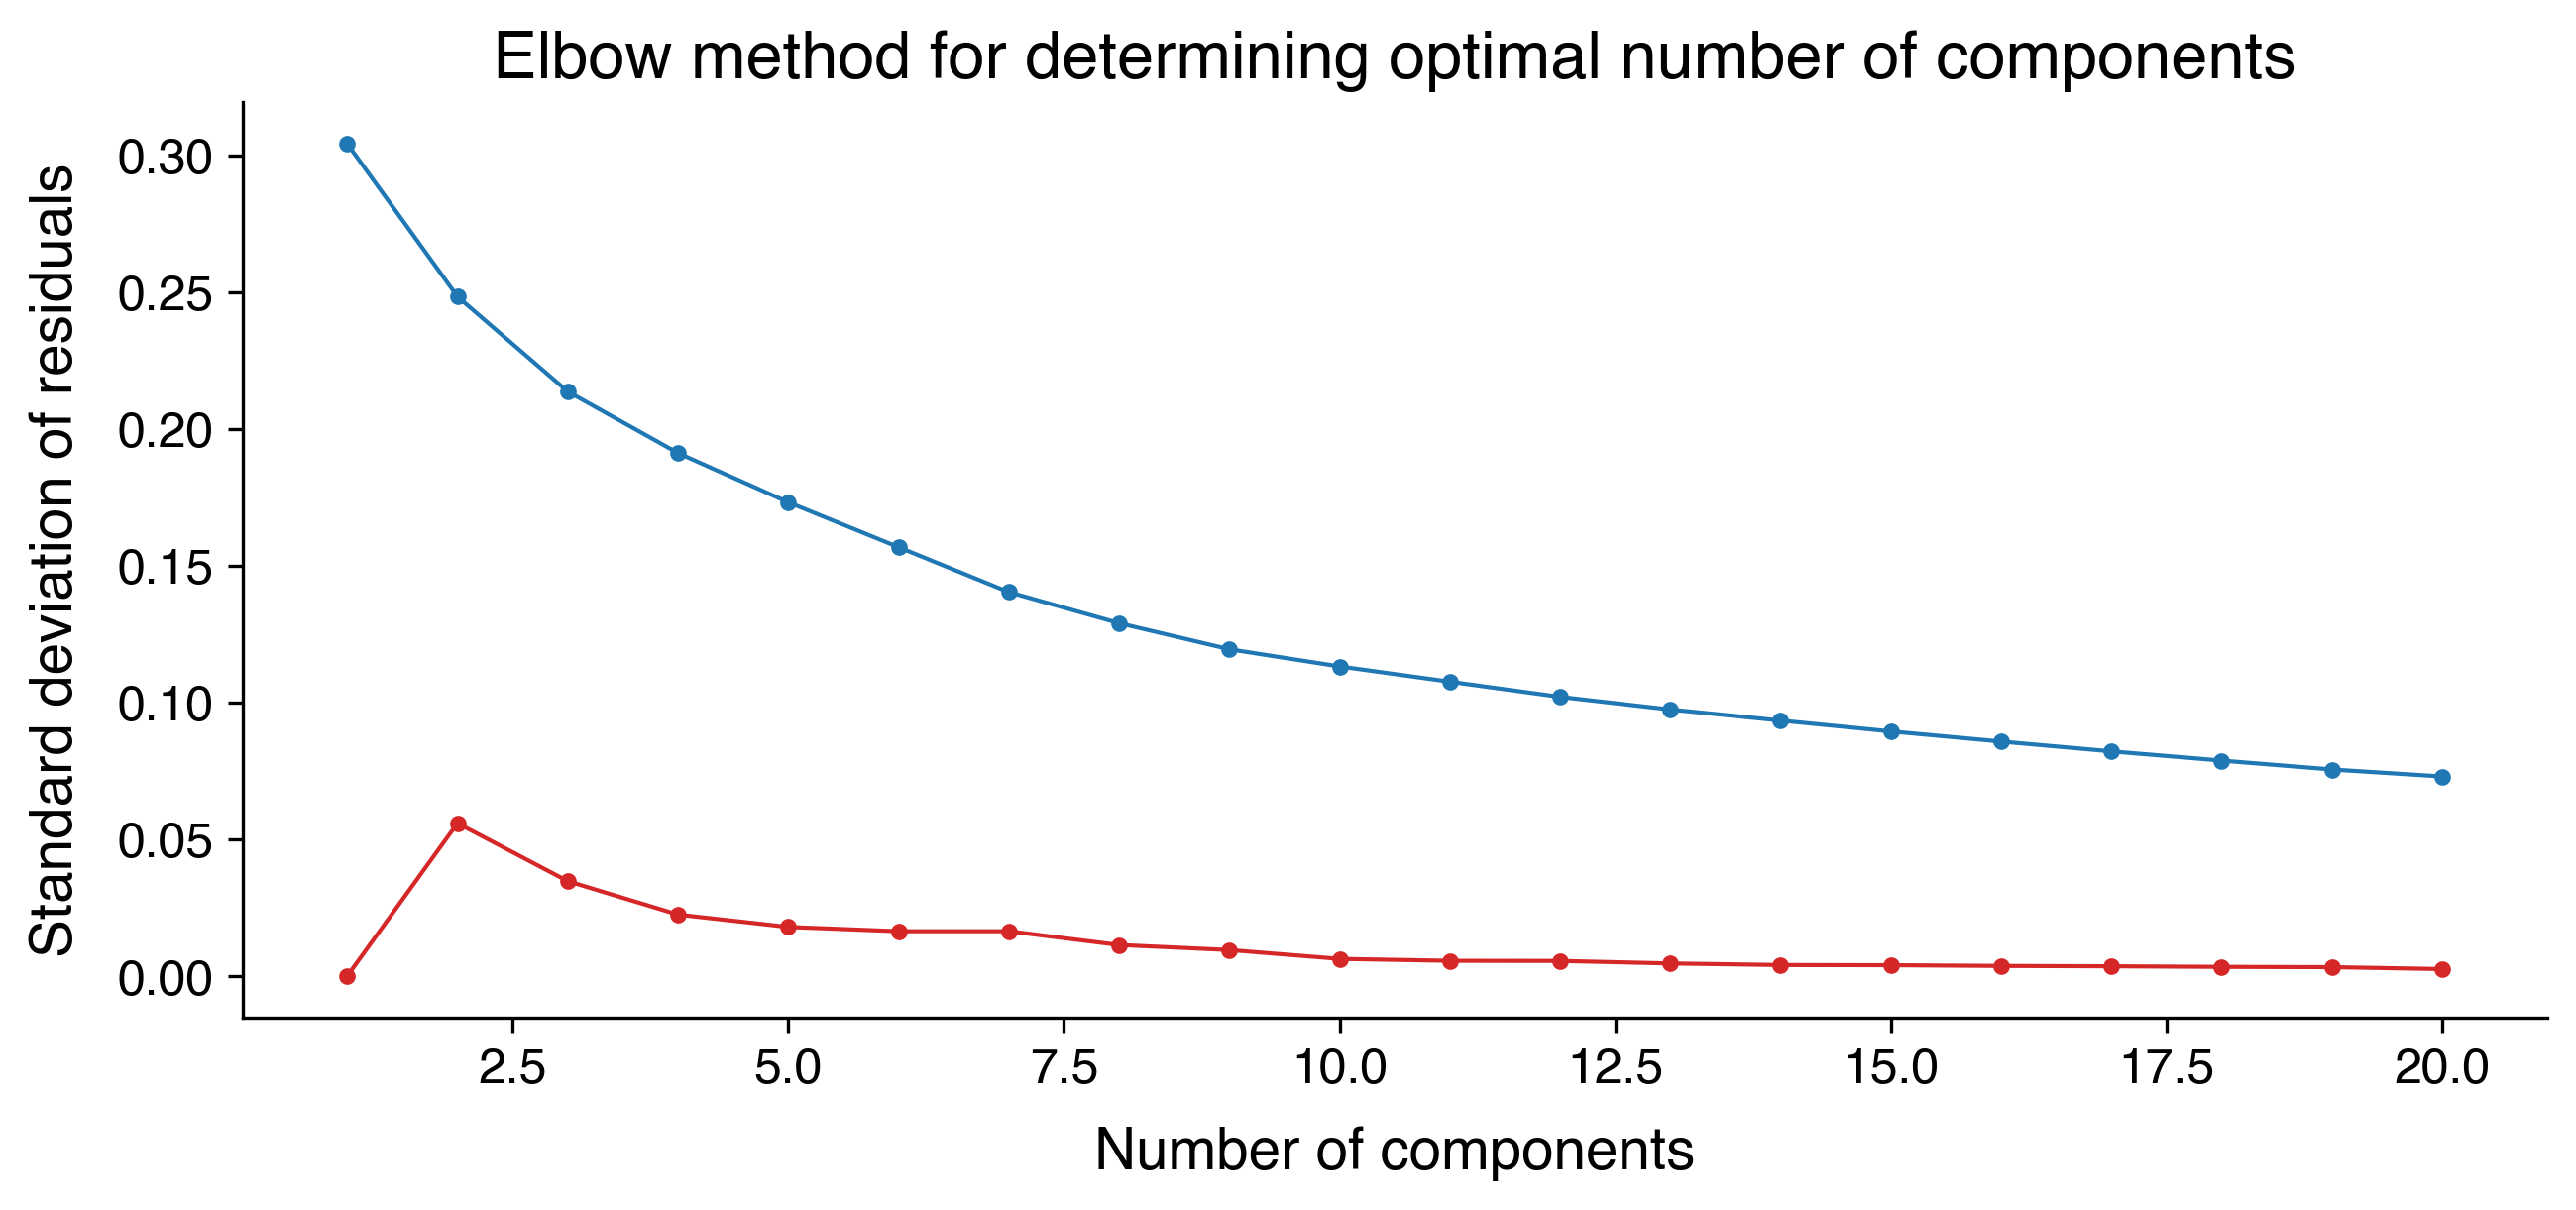

In [199]:
elbow_method(bline_suvrs, max_components=20)

W.shape: (277, 6), H.shape: (6, 72)
Reconstruction error: 22.136484326252493
Std error: 0.1567481697788773


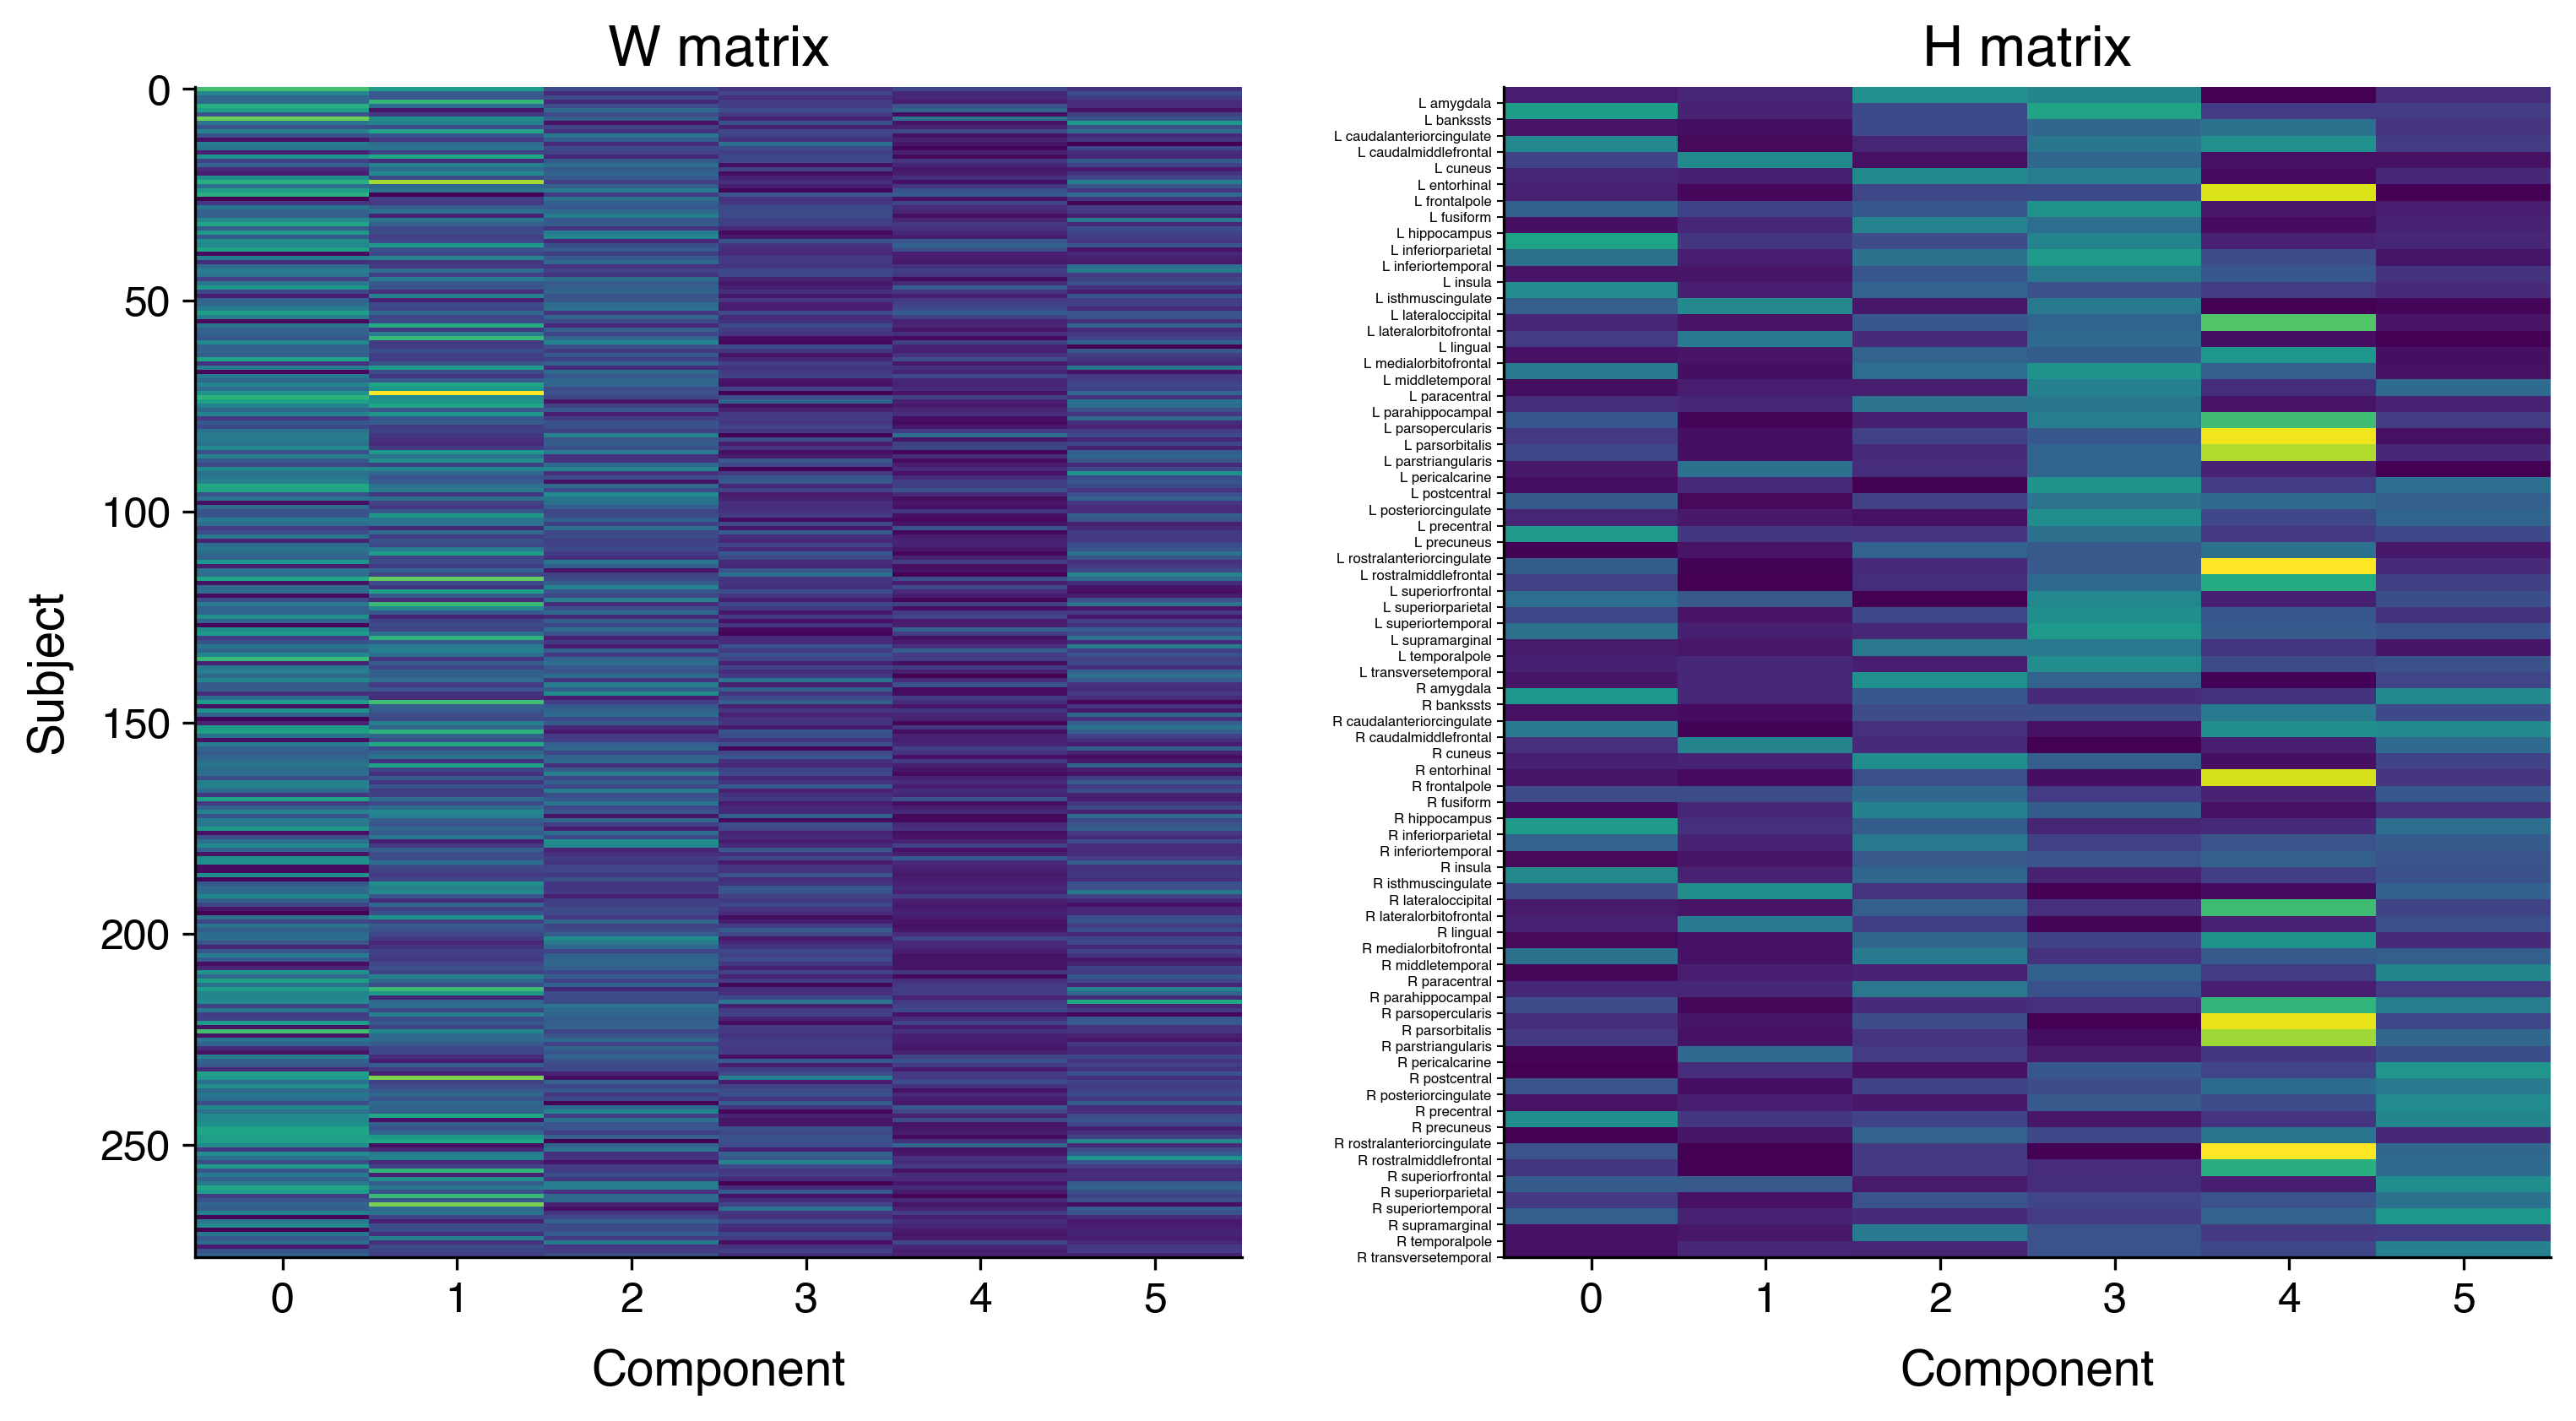

In [205]:
n_components = 6
max_iter = 5000
random_state = None

# ----------------------------------------------------------------------
# Format the data.
keep_cols = ["subj", "roi", "value"]
bline_suvrs = tau_suvrs.query("visit==1")[keep_cols].set_index(["subj", "roi"]).unstack().copy()
bline_suvrs.columns = bline_suvrs.columns.droplevel(0)

# Fit the model.
from sklearn.decomposition import NMF
# model = NMF(n_components=n_components, max_iter=max_iter, init='random', verbose=0)
model = NMF(n_components=n_components, init='random', max_iter=max_iter)
W = model.fit_transform(bline_suvrs) # subj x components
H = model.components_ # components x roi
print("W.shape: {}, H.shape: {}".format(W.shape, H.shape))
print("Reconstruction error: {}".format(model.reconstruction_err_))
print("Std error: {}".format(np.std(bline_suvrs.values - W.dot(H))))

roi_comps = pd.DataFrame(H,
                         index=pd.Series(np.arange(1, n_components+1), name="component"),
                         columns=bline_suvrs.columns).T

# Plot the W and H matrices.
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.imshow(W, aspect="auto", cmap="viridis")
_ax.set_xlabel("Component")
_ax.set_ylabel("Subject")
_ax.set_title("W matrix")

iax = 1
_ax = ax[iax]
_ax.imshow(roi_comps, aspect="auto", cmap="viridis")
_ax.set_xlabel("Component")
_ax.set_title("H matrix")
_ax.tick_params(axis="y", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad, rotation=0)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel("")

plt.show()

In [281]:
from sklearn.decomposition import PCA

def elbow_method_pca(df, max_components=12, standardize=False):
    """
    Apply Principal Component Analysis (PCA) to a pandas dataframe using scikit-learn's PCA class
    and plot the amount of variance explained as a function of the number of components to determine
    the optimal number of components.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to apply PCA to.
    max_components : int, optional (default=10)
        The maximum number of components to use in the PCA model.

    Returns:
    --------
    None
    """
    if standardize:
        df = stats.zscore(df, axis=0)

    mod = PCA(n_components=max_components, svd_solver="full")
    mod.fit(df)


    # Plot the results
    plt.close("all")
    fig, ax = plt.subplots()
    # ax.plot(range(1, max_components+1), mod.explained_variance_ratio_, 'o-')
    ax.plot(range(1, max_components+1), np.cumsum(mod.explained_variance_ratio_), 'o--')
    # ax.set_yscale("log")
    # ax.set_xscale("log")

    ax.set_xlabel('Number of components')
    ax.set_ylabel('Explained variance')
    ax.set_title('Elbow method for determining optimal number of components (PCA)')

    plt.show()


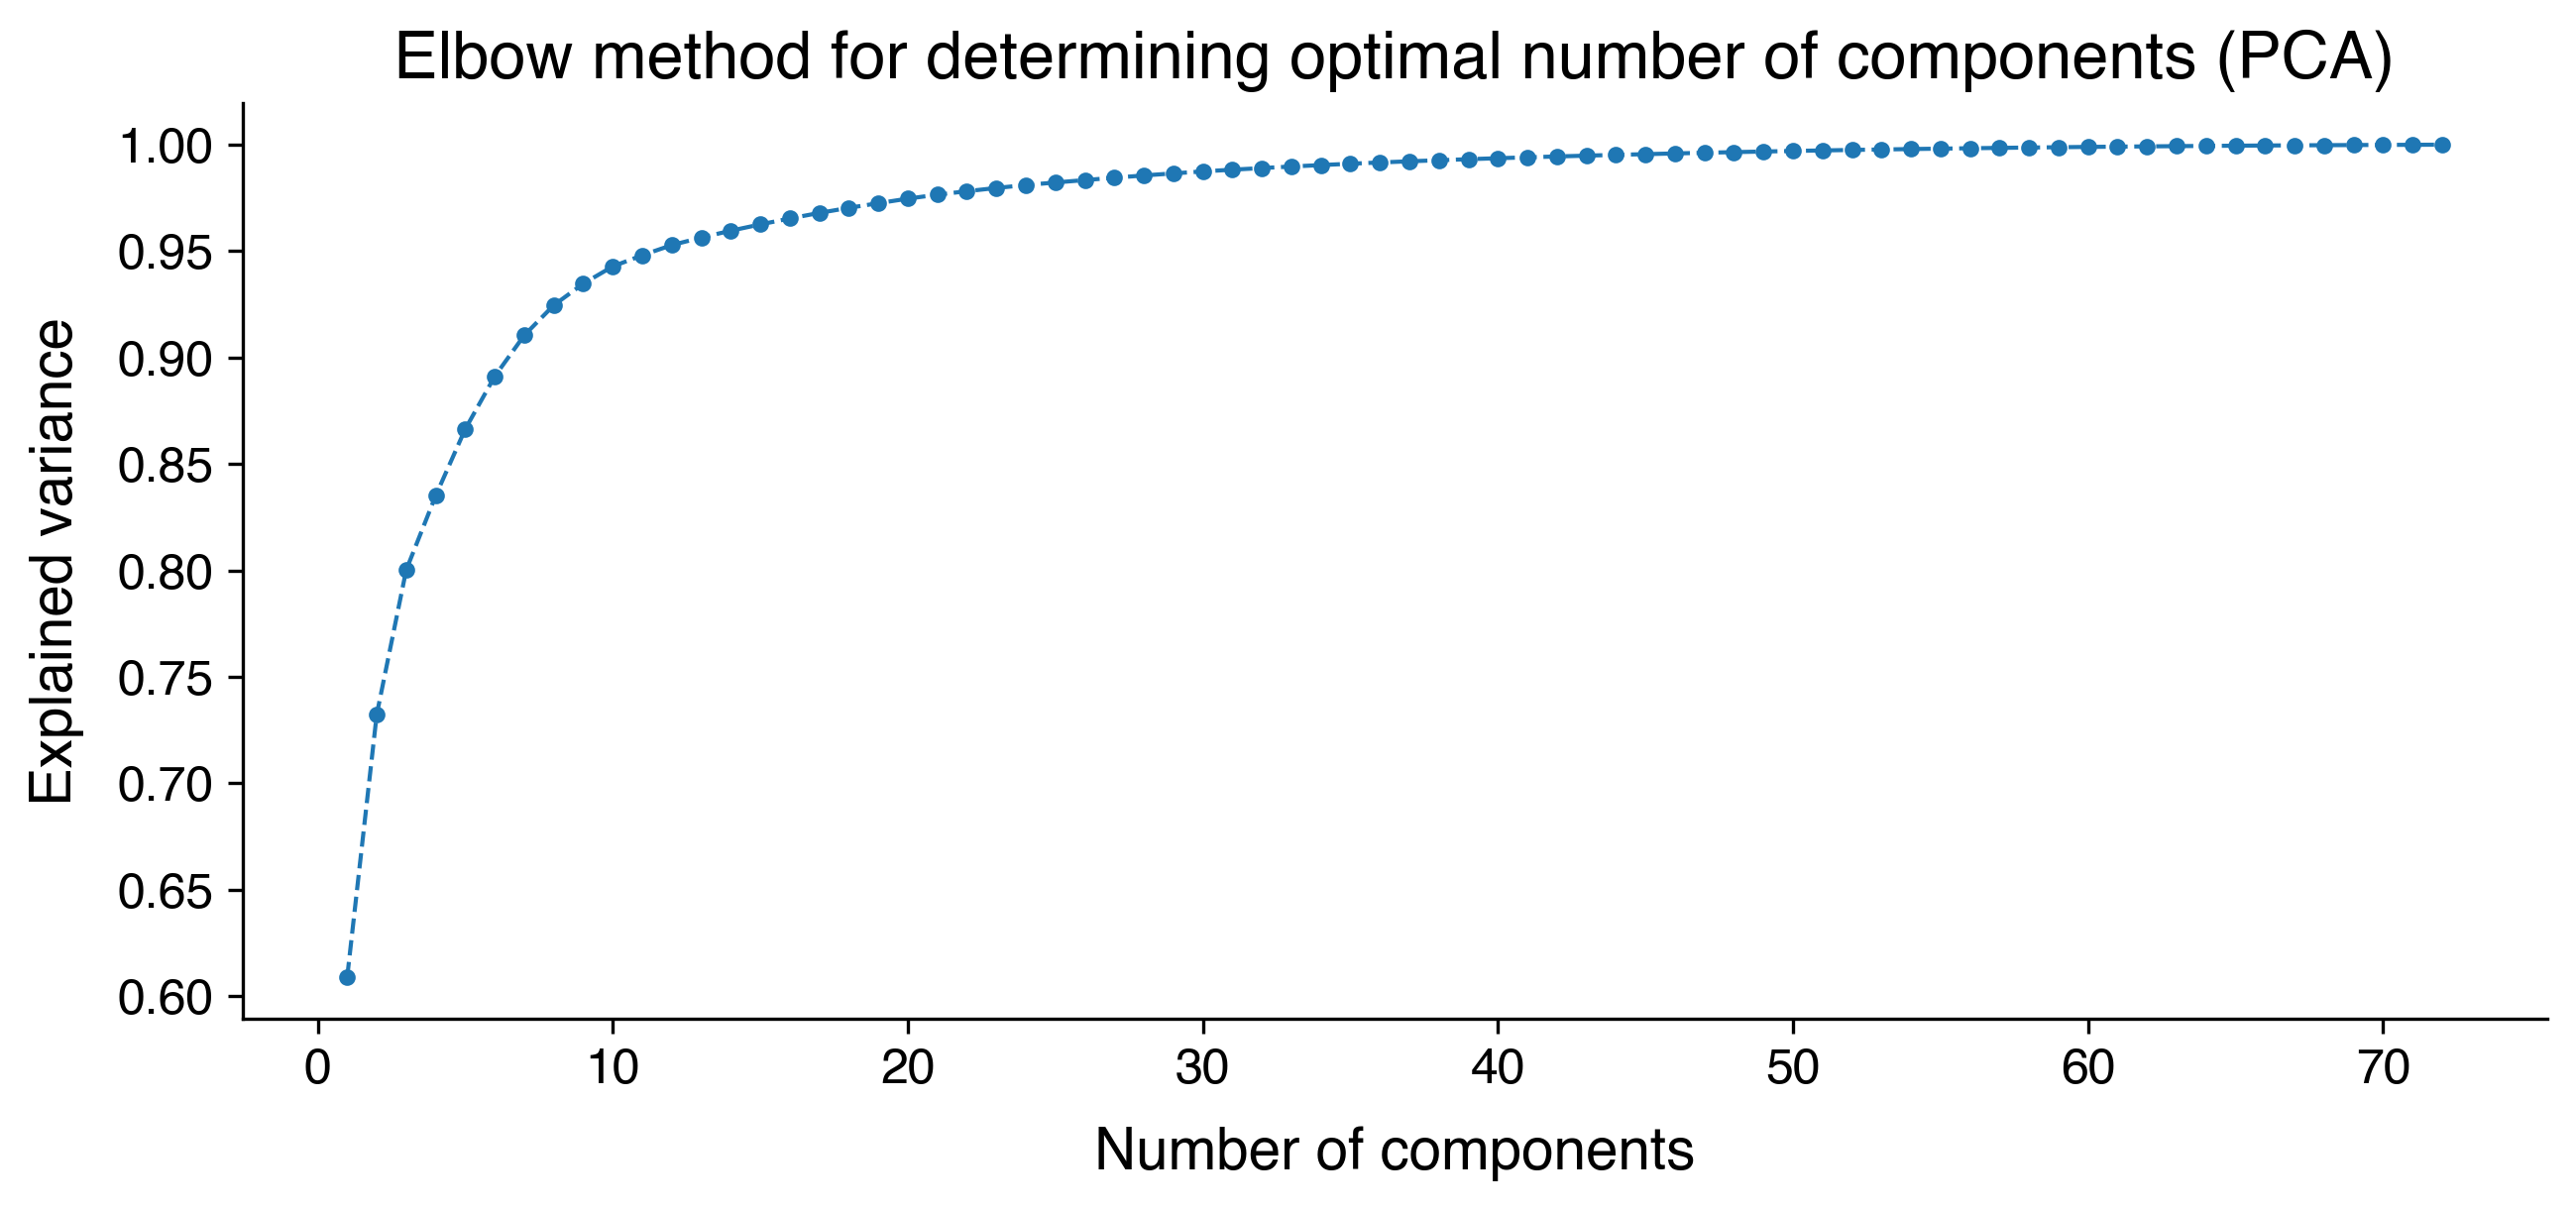

In [283]:
elbow_method_pca(bline_suvrs, max_components=72, standardize=True)

In [274]:
stats.zscore(bline_suvrs, axis=0)

hemroi      L_amygdala  L_bankssts  L_caudalanteriorcingulate  \
subj                                                            
LDS0070166    0.541275    1.527911                   2.448345   
LDS0070174   -1.335090    0.572541                  -0.230773   
LDS0070199   -0.099008   -0.499434                  -0.738976   
LDS0070243   -0.433383    0.024144                  -1.071249   
LDS0070263   -0.628328    1.364332                   3.148041   
...                ...         ...                        ...   
LDS9410298   -1.540586   -0.198222                  -0.835484   
LDS9410307   -0.027964   -1.084170                   0.134188   
LDS9410355   -1.945481   -1.752617                  -0.872058   
LDS9410450   -0.553462   -0.519173                  -0.513681   
LDS9410459   -0.747551   -0.618601                  -0.633070   

hemroi      L_caudalmiddlefrontal  L_cuneus  L_entorhinal  L_frontalpole  \
subj                                                                       
LDS0070166               2.188242  2.361842      1.241950       1.141403   
LDS0070174               0.796910 -0.142995     -0.900314      -0.534617   
LDS0070199               0.179871 -0.238788     -0.761988      -0.605132   
LDS0070243              -0.470955  1.437479     -1.288640      -0.456368   
LDS0070263               1.760154  0.607596      0.502207       1.706905   
...                           ...       ...           ...            ...   
LDS9410298              -0.764080  0.275136     -0.780848      -0.575751   
LDS9410307               0.126887 -0.840195      0.331473       1.469715   
LDS9410355              -1.174109 -1.110719     -2.271460      -0.430023   
LDS9410450              -0.297756 -0.612561     -0.525191      -0.985348   
LDS9410459              -0.544694 -0.707641     -1.306154      -0.764312   

hemroi      L_fusiform  L_hippocampus  L_inferiorparietal  L_inferiortemporal  \
subj                                                                            
LDS0070166    1.554859       1.294223            1.417277            1.503774   
LDS0070174    0.589286      -1.058605            0.802713            0.580801   
LDS0070199   -0.470976      -0.332596           -0.337768           -0.274571   
LDS0070243   -0.255665      -0.437444            0.366604           -0.691795   
LDS0070263    1.474867      -0.368344            1.606694            1.497095   
...                ...            ...                 ...                 ...   
LDS9410298   -0.080790      -1.824517           -0.413814           -0.141992   
LDS9410307   -0.809564      -0.167354           -0.407441            0.166786   
LDS9410355   -1.701787      -1.798423           -1.635952           -1.635646   
LDS9410450   -0.581609      -0.407266           -0.657742           -0.804221   
LDS9410459   -1.227525      -0.896863           -0.406283           -1.206765   

hemroi      L_insula  L_isthmuscingulate  L_lateraloccipital  \
subj                                                           
LDS0070166  0.771194            2.228185            1.523727   
LDS0070174 -0.142827           -0.085288            0.671527   
LDS0070199 -0.431204            0.021943           -0.372121   
LDS0070243 -0.622485            0.381565            0.923417   
LDS0070263  2.109497            1.245383            1.263510   
...              ...                 ...                 ...   
LDS9410298 -0.911060           -0.941226            0.211942   
LDS9410307 -0.047764            1.106215           -1.174688   
LDS9410355 -1.572372           -1.880875           -0.958101   
LDS9410450 -0.747635           -0.846743           -0.766203   
LDS9410459 -1.001793           -0.137569           -0.824822   

hemroi      L_lateralorbitofrontal  L_lingual  L_medialorbitofrontal  \
subj                                                                   
LDS0070166                1.738938   2.332480               1.690285   
LDS0070174               -0.119327   0.310208              -0.

In [275]:
pca = PCA(svd_solver="full", whiten=True)
# pca.fit(bline_suvrs)
pca.fit(stats.zscore(bline_suvrs, axis=0))
# bline_suvrs_pca = pd.DataFrame(pca.fit_transform(bline_suvrs), index=bline_suvrs.index, columns=bline_suvrs.columns)

PCA(svd_solver='full', whiten=True)

In [278]:
pca.explained_variance_ > 1

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [277]:
pca.explained_variance_ratio_ > (100/72)*1e-2

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [276]:
pca.explained_variance_ratio_[:20], np.cumsum(pca.explained_variance_ratio_)[:20]

(array([0.60889952, 0.12329139, 0.06801669, 0.03492758, 0.03120928,
        0.02481751, 0.01926195, 0.01414746, 0.01013299, 0.00810317,
        0.00524803, 0.00477102, 0.00352942, 0.00322727, 0.00295048,
        0.00279933, 0.00260502, 0.00238647, 0.00218314, 0.002145  ]),
 array([0.60889952, 0.73219091, 0.8002076 , 0.83513518, 0.86634446,
        0.89116198, 0.91042393, 0.92457139, 0.93470438, 0.94280755,
        0.94805558, 0.9528266 , 0.95635602, 0.95958329, 0.96253378,
        0.96533311, 0.96793813, 0.9703246 , 0.97250774, 0.97465274]))

In [255]:
pca.explained_variance_ratio_[:20], np.cumsum(pca.explained_variance_ratio_)[:20]

(array([0.67236684, 0.12184455, 0.0360208 , 0.03087224, 0.02381837,
        0.02130697, 0.01765509, 0.01146632, 0.00934255, 0.00562364,
        0.00486306, 0.004471  , 0.00364983, 0.00301195, 0.00279682,
        0.00249396, 0.00230555, 0.00201019, 0.00182202, 0.00149691]),
 array([0.67236684, 0.79421139, 0.83023219, 0.86110443, 0.8849228 ,
        0.90622978, 0.92388486, 0.93535119, 0.94469373, 0.95031737,
        0.95518043, 0.95965143, 0.96330126, 0.96631321, 0.96911003,
        0.97160399, 0.97390954, 0.97591973, 0.97774175, 0.97923866]))

NameError: name 'for_visual' is not defined

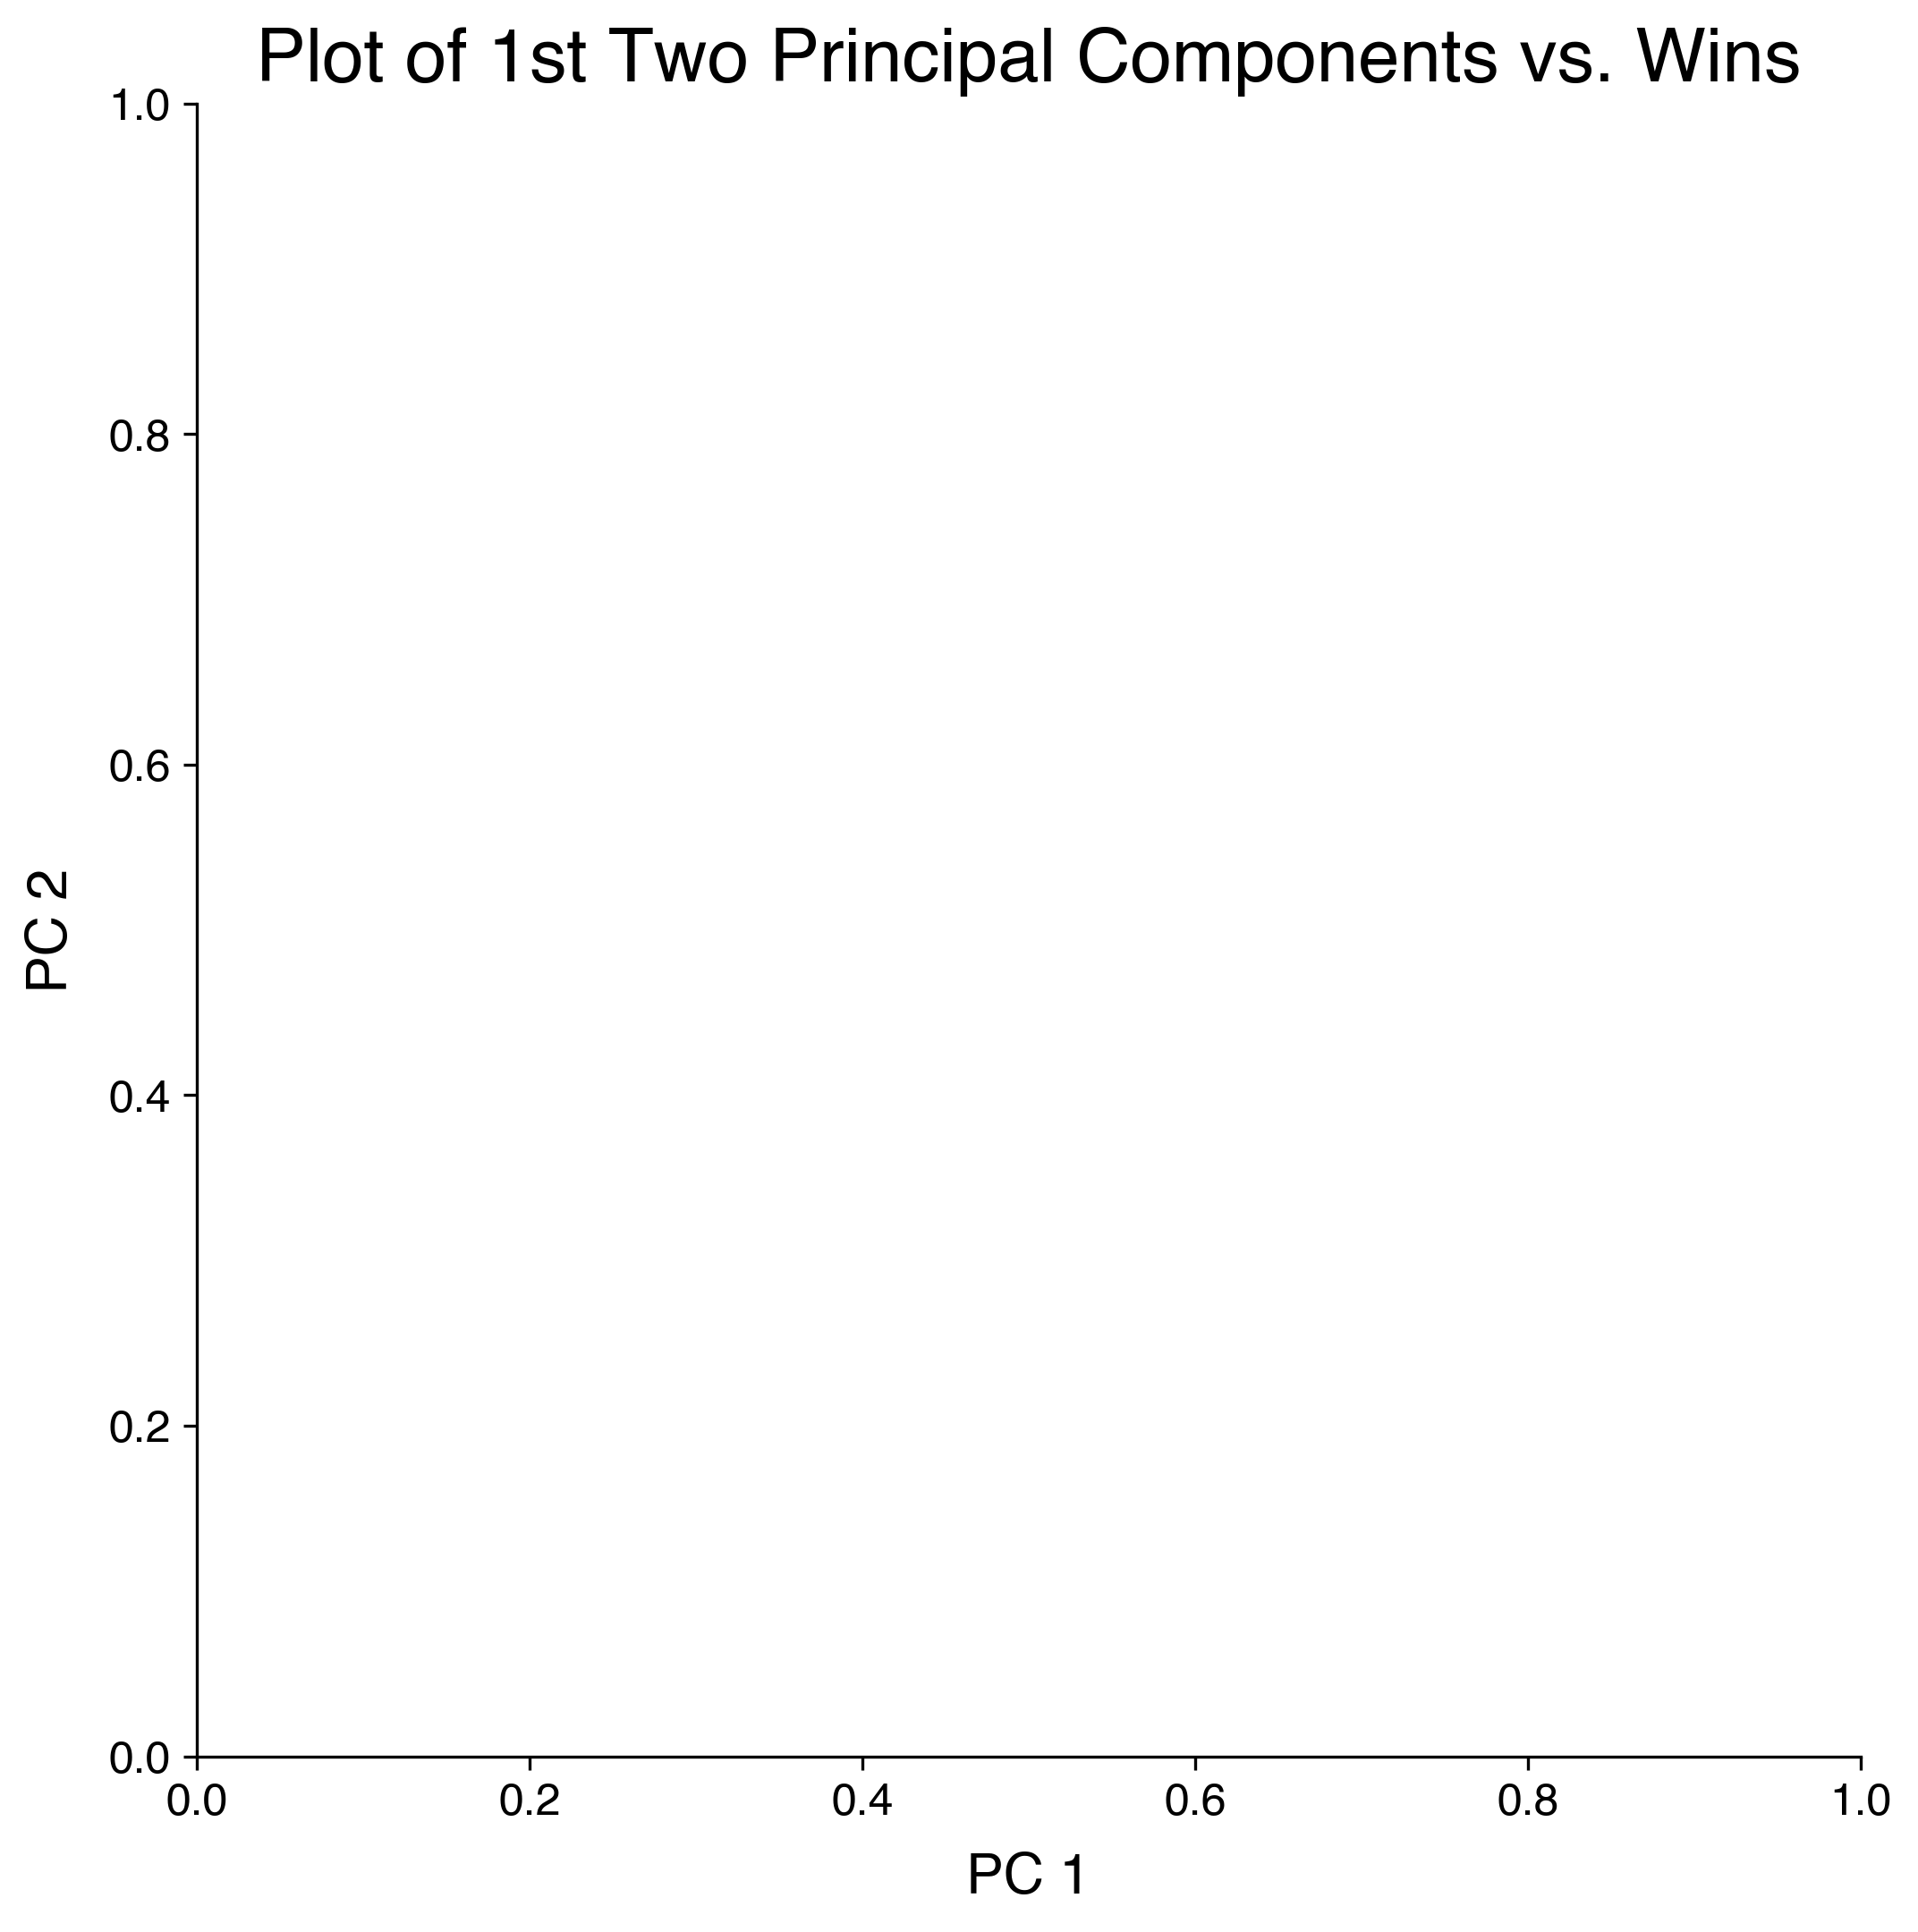

In [258]:
plt.close("all")
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Plot of 1st Two Principal Components vs. Wins', fontsize = 20)
W_GROUP = ['1st 33%','2nd 33%','3rd 33%']
colors = ['navy', 'turquoise', 'darkorange']
for WINS_GROUP, color in zip(W_GROUP,colors):
    indicesToKeep = for_visual['WINS_GROUP'] == WINS_GROUP
    ax.scatter(for_visual.loc[indicesToKeep, 'PC 1']
               , for_visual.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(W_GROUP)
ax.grid()

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=final_df.columns)


In [287]:
from sklearn.cluster import KMeans

def kmeans_clustering(dataframe, num_clusters):
    # Extract the numeric columns from the dataframe
    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()
    numeric_df = dataframe[numeric_cols]
    
    # Fit the k-means model to the numeric dataframe
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(numeric_df)
    
    # Add the cluster labels to the original dataframe
    dataframe['Cluster'] = kmeans.labels_
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(dataframe.iloc[:,0], dataframe.iloc[:,1], c=dataframe['Cluster'], cmap='tab10')
    ax.set_xlabel(dataframe.columns[0])
    ax.set_ylabel(dataframe.columns[1])
    ax.set_title('K-Means Clustering with {} Clusters'.format(num_clusters))
    plt.show()


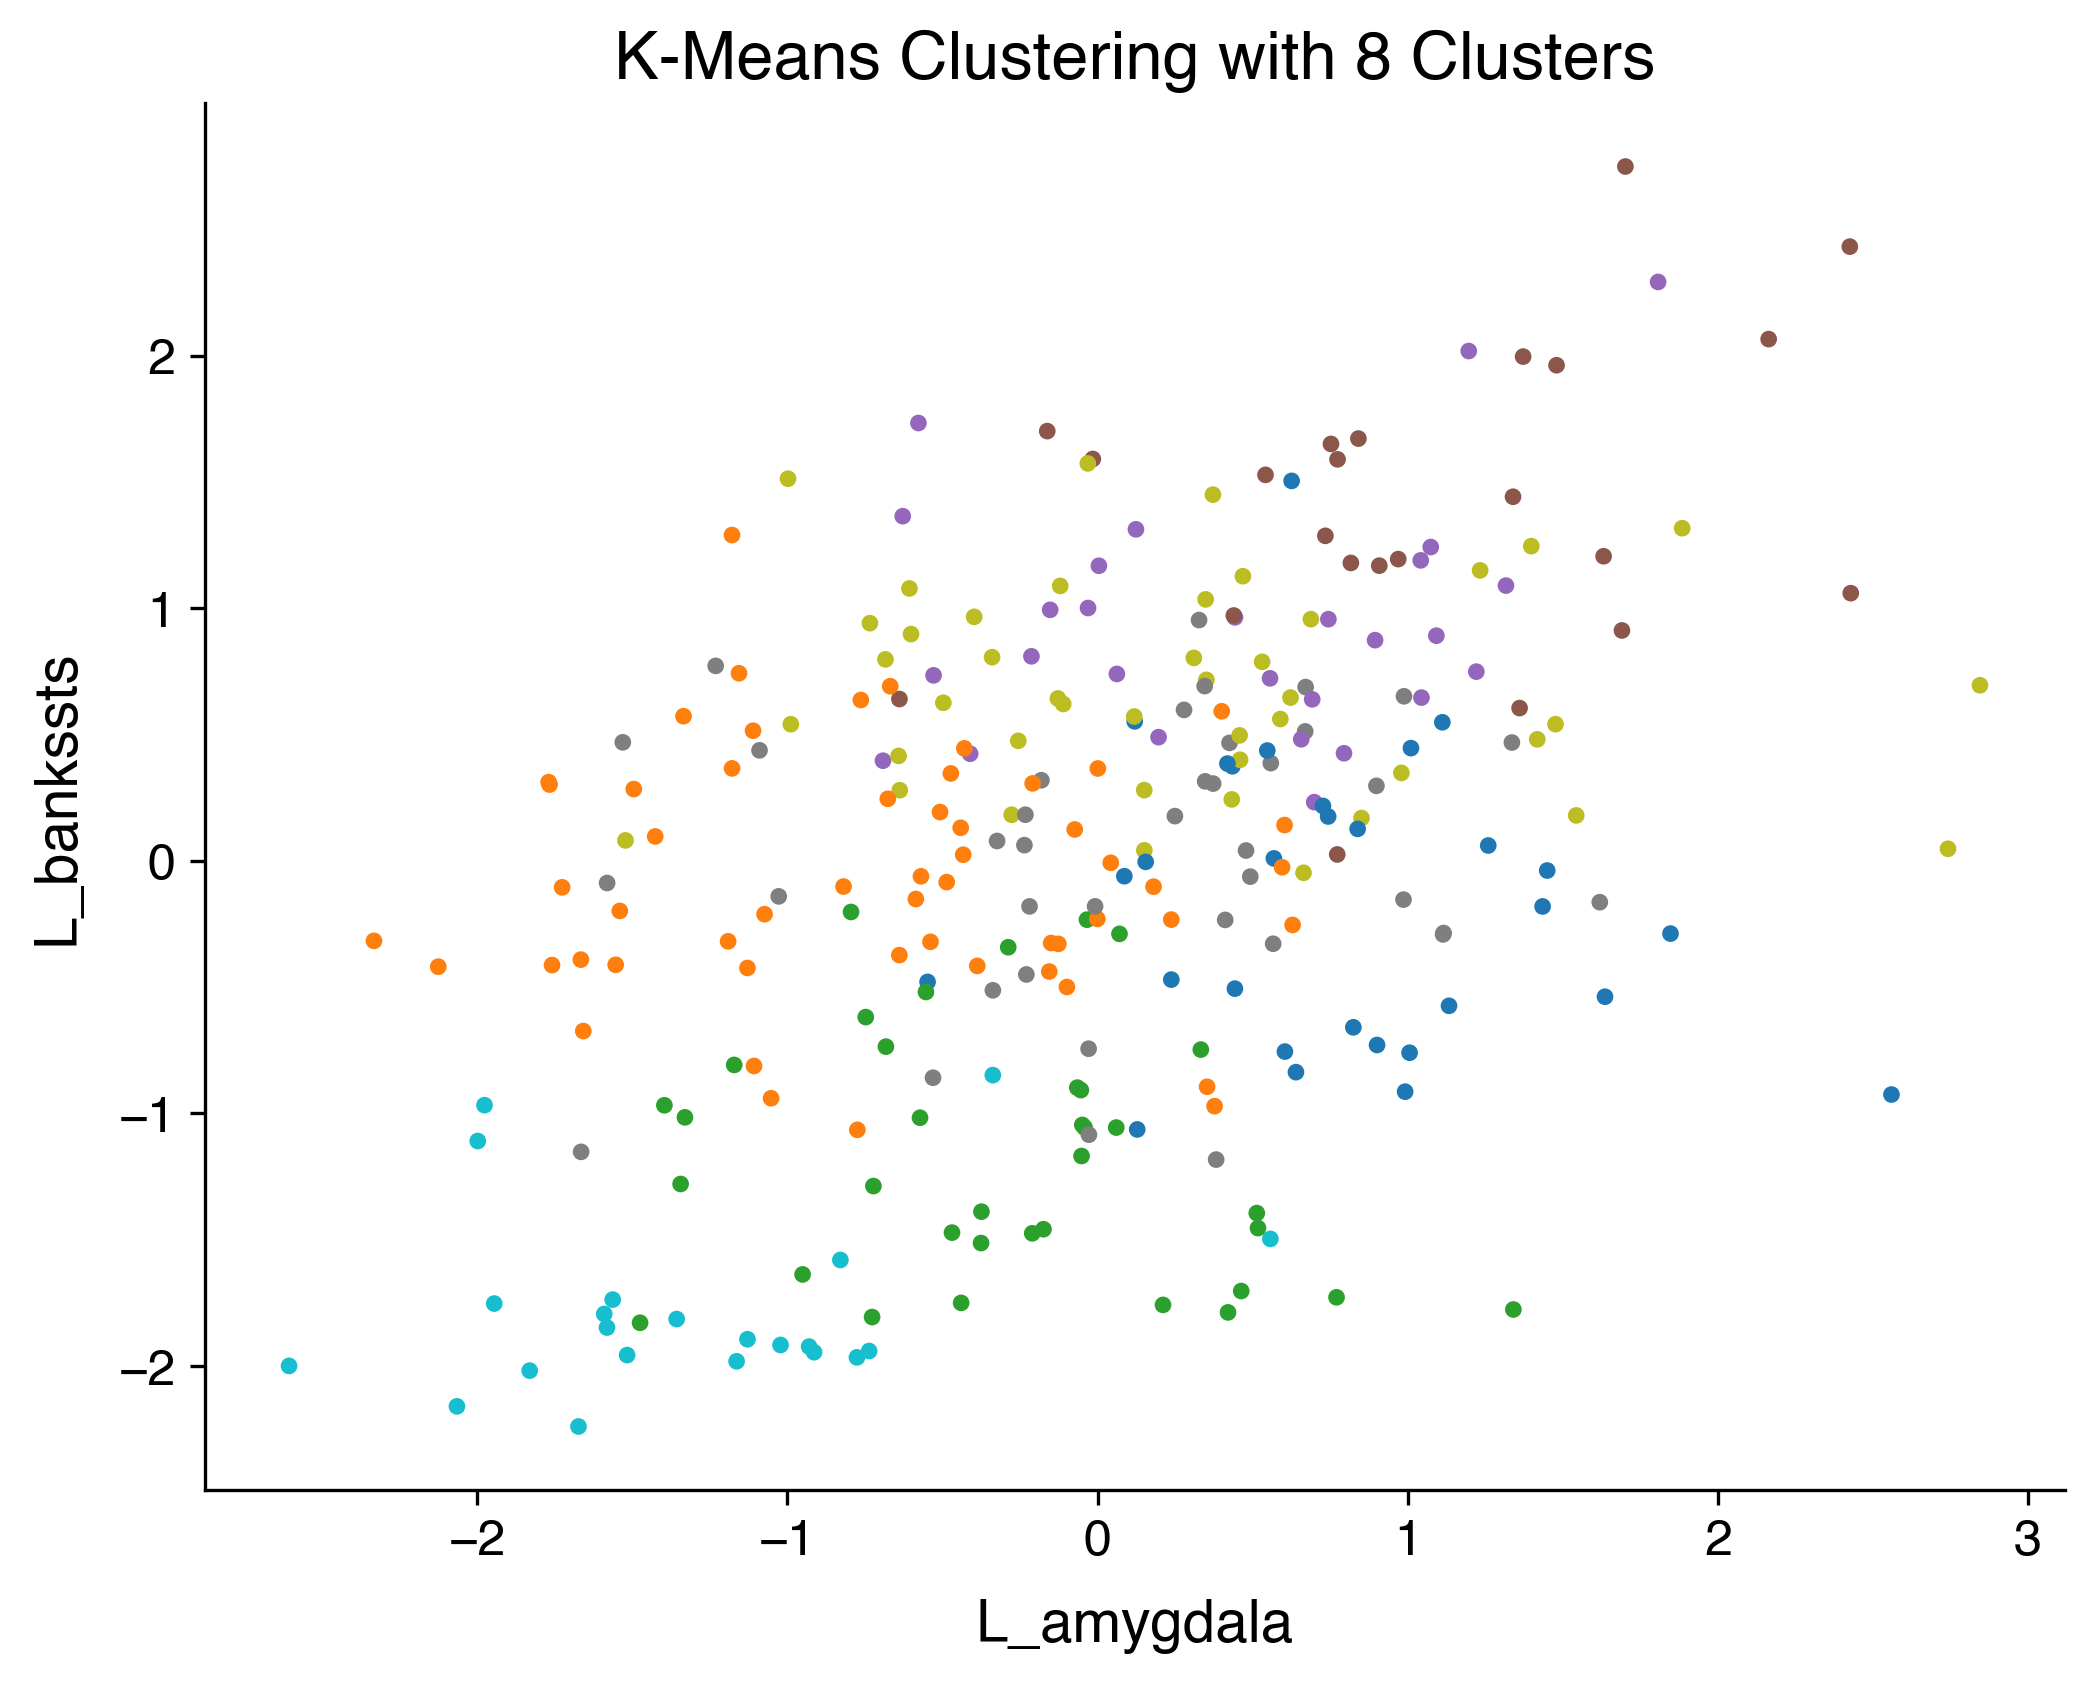

In [289]:
kmeans_clustering(stats.zscore(bline_suvrs, axis=0), 8)

In [309]:
#bline_suvrs.iloc[:, :-1].T

In [335]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=2).fit(stats.zscore(bline_suvrs.iloc[:, :-1], axis=0).T)

In [336]:
pd.DataFrame(np.array([bline_suvrs.columns.tolist()[:-1], optics.labels_]).T, columns=["roi", "cluster"]).groupby("cluster")["roi"].apply(lambda x: list(x))

cluster
-1    [L_caudalmiddlefrontal, L_frontalpole, L_fusif...
0                              [L_amygdala, R_amygdala]
1                        [L_hippocampus, R_hippocampus]
10             [L_superiorparietal, R_superiorparietal]
11    [L_cuneus, L_lateraloccipital, L_lingual, L_pe...
12    [R_cuneus, R_lateraloccipital, R_lingual, R_pe...
13         [R_parstriangularis, R_rostralmiddlefrontal]
14    [L_medialorbitofrontal, L_rostralanteriorcingu...
15                                 [L_insula, R_insula]
16    [L_caudalanteriorcingulate, R_caudalanteriorci...
17                        [R_postcentral, R_precentral]
18                       [L_paracentral, R_paracentral]
19                        [L_postcentral, L_precentral]
2                          [L_entorhinal, R_entorhinal]
20                     [L_temporalpole, R_temporalpole]
3                [L_parahippocampal, R_parahippocampal]
4     [R_fusiform, R_inferiortemporal, R_middletempo...
5                            [L_precuneu

In [354]:
from sklearn.cluster import SpectralClustering
n_clusters = 8

X = stats.zscore(bline_suvrs.iloc[:, :-1], axis=0).T
#X = bline_suvrs.iloc[:, :-1].T
clustering = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0).fit(X)
clustering.labels_

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 2])

In [355]:
rois = np.array(bline_suvrs.columns.tolist()[:-1])
for iClus in range(n_clusters):
    print(iClus, rois[np.where(clustering.labels_ == iClus)[0]])

0 ['L_amygdala' 'L_bankssts' 'L_caudalanteriorcingulate'
 'L_caudalmiddlefrontal' 'L_cuneus' 'L_frontalpole' 'L_fusiform'
 'L_hippocampus' 'L_inferiorparietal' 'L_inferiortemporal' 'L_insula'
 'L_isthmuscingulate' 'L_lateraloccipital' 'L_lateralorbitofrontal'
 'L_lingual' 'L_medialorbitofrontal' 'L_middletemporal' 'L_paracentral'
 'L_parsopercularis' 'L_parsorbitalis' 'L_parstriangularis'
 'L_pericalcarine' 'L_postcentral' 'L_posteriorcingulate' 'L_precentral'
 'L_precuneus' 'L_rostralanteriorcingulate' 'L_rostralmiddlefrontal'
 'L_superiorfrontal' 'L_superiorparietal' 'L_superiortemporal'
 'L_supramarginal' 'R_amygdala' 'R_bankssts' 'R_caudalanteriorcingulate'
 'R_caudalmiddlefrontal' 'R_cuneus' 'R_frontalpole' 'R_fusiform'
 'R_hippocampus' 'R_inferiorparietal' 'R_inferiortemporal' 'R_insula'
 'R_isthmuscingulate' 'R_lateraloccipital' 'R_lateralorbitofrontal'
 'R_lingual' 'R_medialorbitofrontal' 'R_middletemporal' 'R_paracentral'
 'R_parsopercularis' 'R_parsorbitalis' 'R_parstriangula

In [215]:
roi_comps.sort_values(by=3, ascending=False).head(20)

component                          1         2         3         4         5  \
hemroi                                                                         
L_amygdala                  0.176972  0.237281  1.135188  1.016216  0.000000   
R_amygdala                  0.139715  0.261829  1.130572  0.712776  0.025992   
R_entorhinal                0.192319  0.217022  1.100335  0.680737  0.088696   
L_entorhinal                0.230854  0.199463  1.064058  0.960827  0.064251   
L_hippocampus               0.092078  0.247503  0.992369  0.804524  0.069994   
R_hippocampus               0.070981  0.255083  0.983376  0.659373  0.098480   
R_middletemporal            0.839563  0.107124  0.926892  0.324573  0.630074   
R_temporalpole              0.110436  0.142989  0.920605  0.575085  0.371420   
R_inferiortemporal          0.700347  0.225798  0.907738  0.430215  0.569770   
L_temporalpole              0.163438  0.140781  0.891879  0.920808  0.349824   
R_parahippocampal           0.255406  0.259924  0.888752  0.565298  0.178164   
L_parahippocampal           0.295373  0.237098  0.856164  0.867551  0.118349   
L_inferiortemporal          0.842702  0.183893  0.844915  1.208247  0.527824   
L_middletemporal            0.920761  0.088188  0.807187  1.139398  0.672058   
R_medialorbitofrontal       0.054522  0.109576  0.752703  0.455485  1.146377   
R_fusiform                  0.520009  0.526800  0.743589  0.396825  0.220923   
R_isthmuscingulate          1.054491  0.208450  0.735268  0.217800  0.411121   
R_rostralanteriorcingulate  0.000000  0.123925  0.714867  0.479043  0.868643   
L_isthmuscingulate          1.078584  0.191948  0.709895  0.553387  0.394334   
L_medialorbitofrontal       0.109102  0.120218  0.709751  0.659444  1.175805   

component                          6  
hemroi                                
L_amygdala                  0.287306  
R_amygdala                  0.469591  
R_entorhinal                0.448224  
L_entorhinal                0.259817  
L_hippocampus               0.216183  
R_hippocampus               0.300439  
R_middletemporal            0.674652  
R_temporalpole              0.403503  
R_inferiortemporal          0.646890  
L_temporalpole              0.139729  
R_parahippocampal           0.385990  
L_parahippocampal           0.214337  
L_inferiortemporal          0.127589  
L_middletemporal            0.102031  
R_medialorbitofrontal       0.278809  
R_fusiform                  0.618375  
R_isthmuscingulate          0.557646  
R_rostralanteriorcingulate  0.260712  
L_isthmuscingulate          0.267746  
L_medialorbitofrontal       0.087553

In [210]:
pd.DataFrame({comp: roi_comps.sort_values(by=comp, ascending=False).index.tolist() for comp in range(1, n_components+1)}).head(10)

1                   2                   3  \
0     L_inferiorparietal  R_lateraloccipital          L_amygdala   
1             L_bankssts            L_cuneus          R_amygdala   
2     R_inferiorparietal  L_lateraloccipital        R_entorhinal   
3            L_precuneus            R_cuneus        L_entorhinal   
4             R_bankssts           L_lingual       L_hippocampus   
5            R_precuneus           R_lingual       R_hippocampus   
6     L_isthmuscingulate     L_pericalcarine    R_middletemporal   
7     R_isthmuscingulate     R_pericalcarine      R_temporalpole   
8  L_caudalmiddlefrontal  L_superiorparietal  R_inferiortemporal   
9       L_middletemporal  R_superiorparietal      L_temporalpole   

                      4                       5                      6  
0            L_bankssts  R_rostralmiddlefrontal        R_supramarginal  
1    L_inferiortemporal  L_rostralmiddlefrontal          R_postcentral  
2       L_supramarginal         L_parsorbitalis     R_superiorparietal  
3            L_fusiform         R_parsorbitalis           R_precentral  
4         L_postcentral           L_frontalpole             R_bankssts  
5      L_middletemporal           R_frontalpole  R_caudalmiddlefrontal  
6    L_superiortemporal      L_parstriangularis            R_precuneus  
7          L_precentral      R_parstriangularis          R_paracentral  
8  L_transversetemporal  L_lateralorbitofrontal   R_transversetemporal  
9    L_superiorparietal       L_parsopercularis      R_parsopercularis

best n_components by PCA CV = 33
best n_components by FactorAnalysis CV = 28
best n_components by PCA MLE = 64


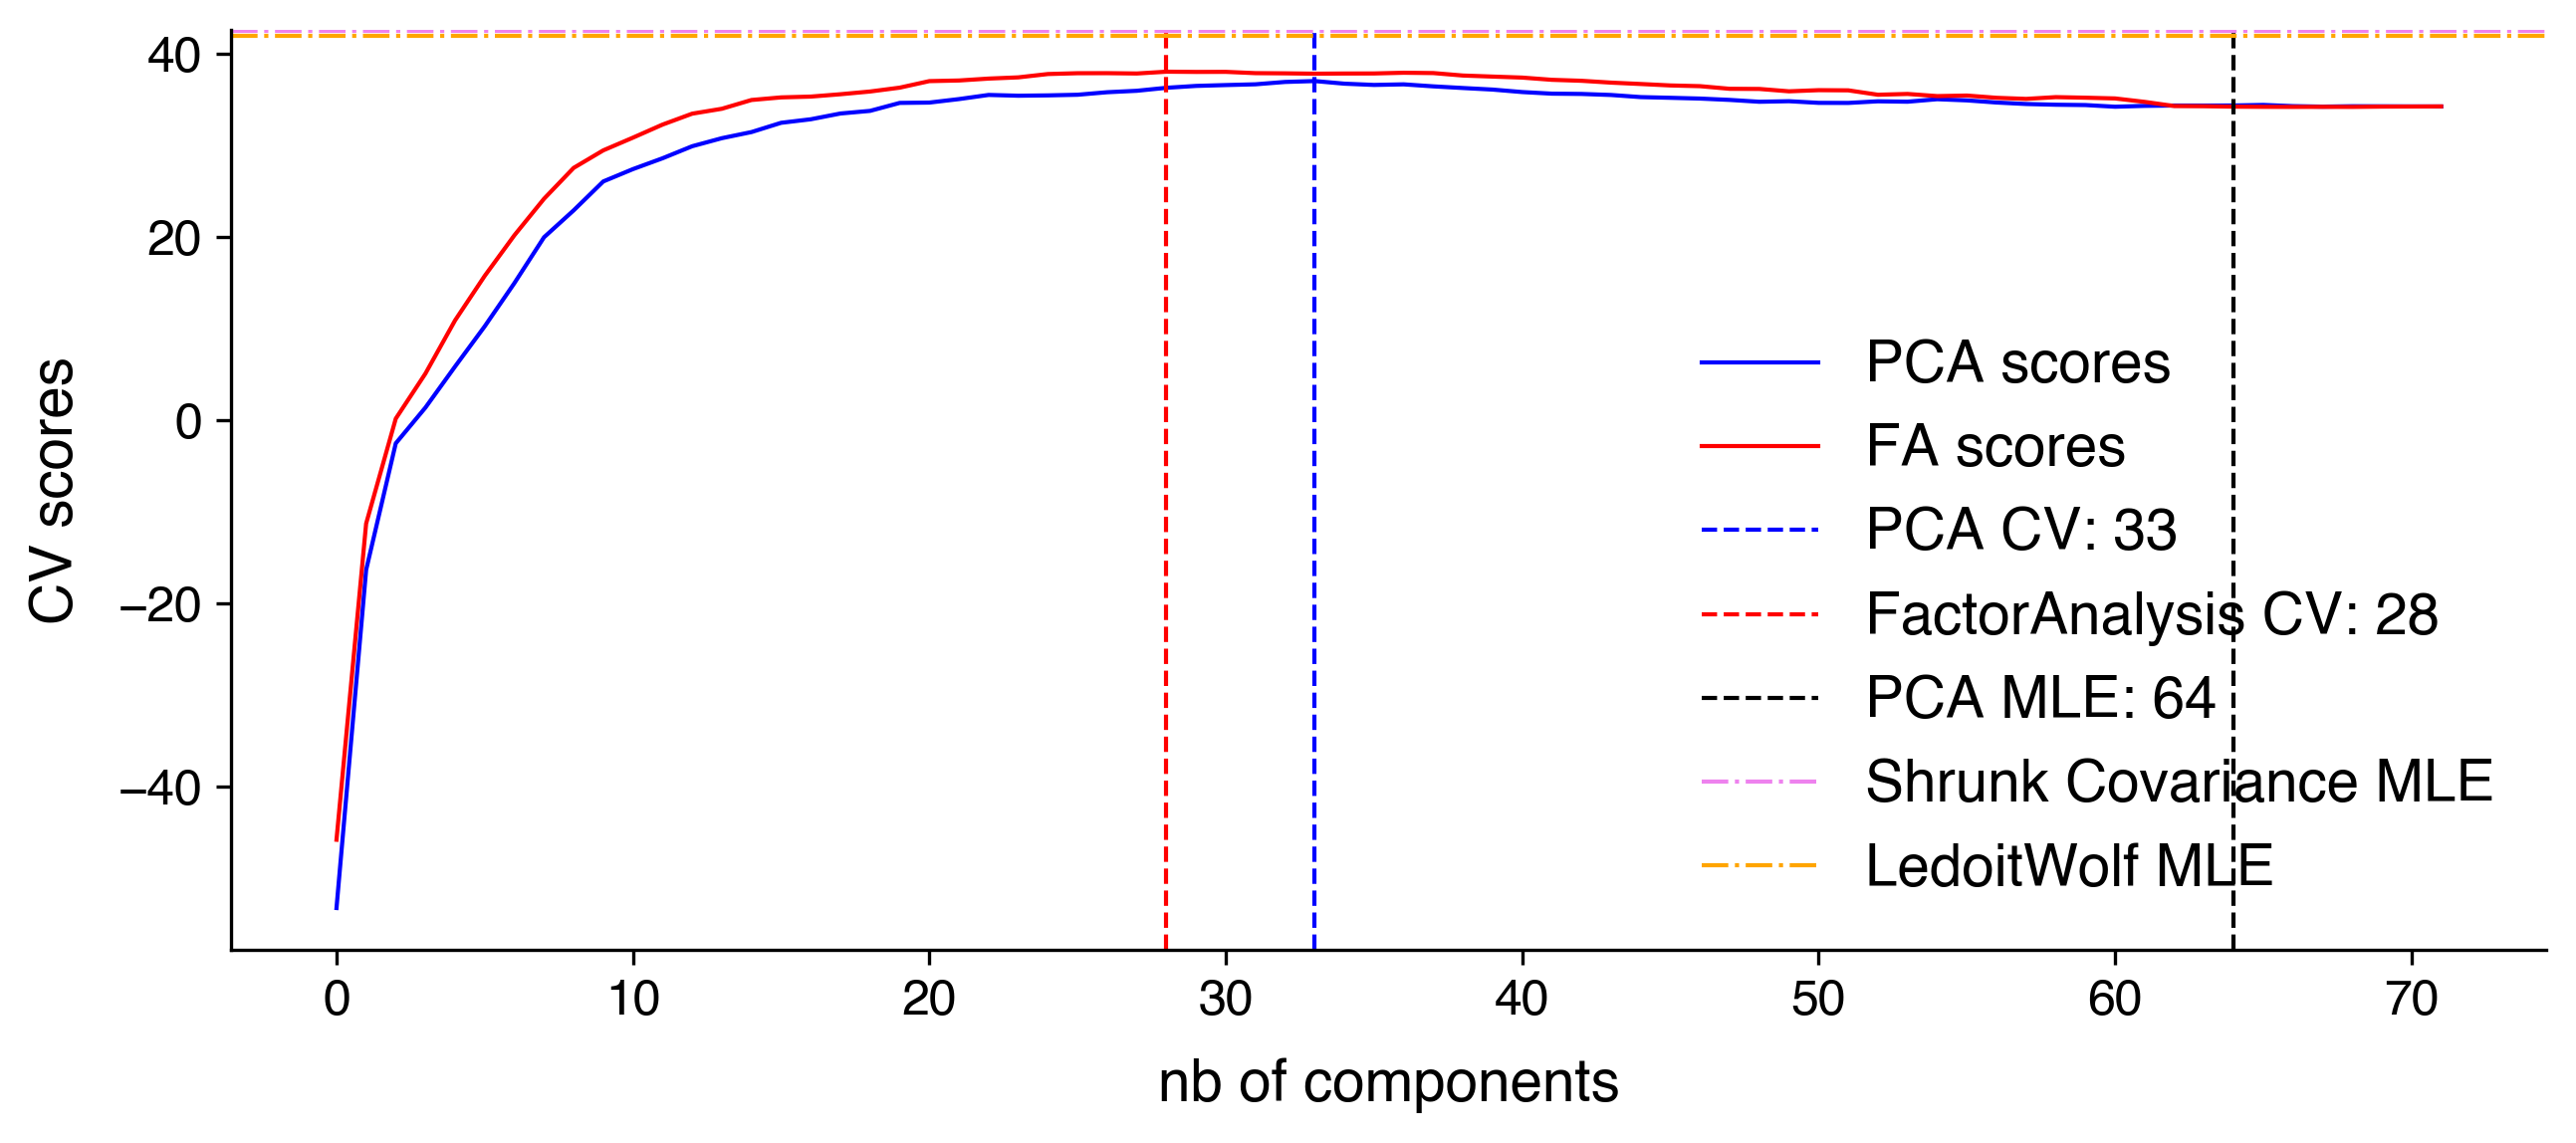

In [219]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

n_features = 72
n_components = np.arange(0, n_features)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


X = bline_suvrs.copy()
pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(svd_solver="full", n_components="mle")
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.close("all")
plt.figure()
plt.plot(n_components, pca_scores, "b", label="PCA scores")
plt.plot(n_components, fa_scores, "r", label="FA scores")
plt.axvline(
    n_components_pca,
    color="b",
    label="PCA CV: %d" % n_components_pca,
    linestyle="--",
)
plt.axvline(
    n_components_fa,
    color="r",
    label="FactorAnalysis CV: %d" % n_components_fa,
    linestyle="--",
)
plt.axvline(
    n_components_pca_mle,
    color="k",
    label="PCA MLE: %d" % n_components_pca_mle,
    linestyle="--",
)

# compare with other covariance estimators
plt.axhline(
    shrunk_cov_score(X),
    color="violet",
    label="Shrunk Covariance MLE",
    linestyle="-.",
)
plt.axhline(
    lw_score(X),
    color="orange",
    label="LedoitWolf MLE" % n_components_pca_mle,
    linestyle="-.",
)

plt.xlabel("nb of components")
plt.ylabel("CV scores")
plt.legend(loc="lower right")

plt.show()

In [ ]:
# Fit a linear mixed effects model predicting FTP SUVR over time,
# separately for each roi.
min_pet_visits = 2
# solvers = ["lbfgs", "bfgs", "cg", "nm", "powell"]
solvers = ["powell"]
verbose = False

# ----------------------------------------------------------------------
warnings.filterwarnings("ignore")
tau_suvrs_mem = []
for solver in solvers:
    if verbose:
        print(roi)
    # Fit a linear mixed effects model to estimate random intercepts and
    # random slopes for each subject, and a fixed effect for years_from_bline.
    keep_cols = ["subj", "years_from_bline", "age_at_pet", "pet_visits", "roi", "value"]
    dat = tau_suvrs.query("(pet_visits>={}) & (roi=='{}')".format(min_pet_visits, roi))[keep_cols]
    md = smf.mixedlm("value ~ roi + years_from_bline + roi:years_from_bline", dat, groups=dat["subj"], re_formula="~years_from_bline")
    # md = smf.mixedlm("value ~ 1", dat, groups=dat["subj"], re_formula="~years_from_bline")
    mdf = md.fit(method=solver)

    # Add the model predictions and residuals.
    dat["solver"] = solver
    dat["converged"] = mdf.converged
    dat["pred"] = mdf.fittedvalues
    dat["resid"] = mdf.resid

    # Add the fixed effects.
    dat["fe_icpt"] = mdf.params["Intercept"]
    if "years_from_bline" in mdf.params.index:
        dat["fe_years_from_bline"] = mdf.params["years_from_bline"]
    else:
        dat["fe_years_from_bline"] = 0

    # Add the random effects.
    modef = pd.concat(mdf.random_effects, axis=1).T.reset_index()
    modef.columns = ["subj", "re_icpt", "re_years_from_bline"]
    modef.insert(1, "roi", roi)
    dat = dat.merge(modef, on=["subj", "roi"], how="left")

    # Combine fixed and random effects.
    dat["md_icpt"] = dat["fe_icpt"] + dat["re_icpt"]
    dat["md_years_from_bline"] = dat["fe_years_from_bline"] + dat["re_years_from_bline"]

    # Concatenate the data.
    tau_suvrs_mem.append(dat)
    
tau_suvrs_mem = pd.concat(tau_suvrs_mem, axis=0)
warnings.resetwarnings()
print(
    "tau_suvrs_mem",
    "-"*len("tau_suvrs_mem"),
    "Shape: {}".format(tau_suvrs_mem.shape),
    "Number of subjects: {}".format(tau_suvrs_mem["subj"].nunique()),
    "Number of rois: {}".format(tau_suvrs_mem["roi"].nunique()),
    "Number of timepoints/subject: {}-{}, mean={:.1f}".format(tau_suvrs_mem["pet_visits"].min(), tau_suvrs_mem["pet_visits"].max(), tau_suvrs_mem["visit"].mean()),
    "Number of subject x roi combinations: {}".format(tau_suvrs_mem[["subj", "roi"]].drop_duplicates().shape[0]),
    "Number of subject x roi x timepoint combinations: {}".format(tau_suvrs_mem[["subj", "roi", "visit"]].drop_duplicates().shape[0]),
    "All models converged: {}".format(np.all(tau_suvrs_mem["converged"]==True)),
    sep="\n"
)

In [109]:
# Fit a linear mixed effects model predicting FTP SUVR over time,
# separately for each roi.
min_pet_visits = 2
# solvers = ["lbfgs", "bfgs", "cg", "nm", "powell"]
# solvers = ["powell"]
solvers = ["lbfgs"]
verbose = False

# ----------------------------------------------------------------------
warnings.filterwarnings("ignore")
tau_suvrs_mem = []
for roi in np.unique(tau_suvrs["roi"]):
    for solver in solvers:
        if verbose:
            print(roi)
        # Fit a linear mixed effects model to estimate random intercepts and
        # random slopes for each subject, and a fixed effect for years_from_bline.
        keep_cols = ["subj", "years_from_bline", "age_at_pet", "visit", "pet_visits", "roi", "value"]
        dat = tau_suvrs.query("(pet_visits>={}) & (roi=='{}')".format(min_pet_visits, roi))[keep_cols]
        free = sm.regression.mixed_linear_model.MixedLMParams.from_components(np.ones(2), np.eye(2))
        # md = smf.mixedlm("value ~ years_from_bline", dat, groups=dat["subj"], re_formula="~years_from_bline")
        md = smf.mixedlm("value ~ years_from_bline", dat, groups=dat["subj"], re_formula="~years_from_bline")
        # md = smf.mixedlm("value ~ 1", dat, groups=dat["subj"], re_formula="~years_from_bline")
        # md = smf.mixedlm("value ~ 1", dat, groups=dat["subj"], re_formula="~years_from_bline")
        # mdf = md.fit(method=solver)
        mdf = md.fit(method=solver, free=free)

        # Add the model predictions and residuals.
        dat["solver"] = solver
        dat["converged"] = mdf.converged
        dat["pred"] = mdf.fittedvalues
        dat["resid"] = mdf.resid

        # Add the fixed effects.
        dat["fe_icpt"] = mdf.params["Intercept"]
        if "years_from_bline" in mdf.params.index:
            dat["fe_years_from_bline"] = mdf.params["years_from_bline"]
        else:
            dat["fe_years_from_bline"] = 0

        # Add the random effects.
        modef = pd.concat(mdf.random_effects, axis=1).T.reset_index()
        modef.columns = ["subj", "re_icpt", "re_years_from_bline"]
        modef.insert(1, "roi", roi)
        dat = dat.merge(modef, on=["subj", "roi"], how="left")

        # Combine fixed and random effects.
        dat["md_icpt"] = dat["fe_icpt"] + dat["re_icpt"]
        dat["md_years_from_bline"] = dat["fe_years_from_bline"] + dat["re_years_from_bline"]

        # Concatenate the data.
        tau_suvrs_mem.append(dat)

        break
    break
    
tau_suvrs_mem = pd.concat(tau_suvrs_mem, axis=0)
warnings.resetwarnings()
print(
    "tau_suvrs_mem",
    "-"*len("tau_suvrs_mem"),
    "Shape: {}".format(tau_suvrs_mem.shape),
    "Number of subjects: {}".format(tau_suvrs_mem["subj"].nunique()),
    "Number of rois: {}".format(tau_suvrs_mem["roi"].nunique()),
    "Number of timepoints/subject: {}-{}, mean={:.1f}".format(tau_suvrs_mem["pet_visits"].min(), tau_suvrs_mem["pet_visits"].max(), tau_suvrs_mem["visit"].mean()),
    "Number of subject x roi combinations: {}".format(tau_suvrs_mem[["subj", "roi"]].drop_duplicates().shape[0]),
    "Number of subject x roi x timepoint combinations: {}".format(tau_suvrs_mem[["subj", "roi", "visit"]].drop_duplicates().shape[0]),
    "All models converged: {}".format(np.all(tau_suvrs_mem["converged"]==True)),
    sep="\n"
)

tau_suvrs_mem
-------------
Shape: (297, 17)
Number of subjects: 126
Number of rois: 1
Number of timepoints/subject: 2-4, mean=1.8
Number of subject x roi combinations: 126
Number of subject x roi x timepoint combinations: 297
All models converged: True


In [110]:
print(f"Formula: {md.formula}")
print(f"Random intercept ~ slope correlation: {mdf.cov_re.iloc[0, 1] / np.sqrt(mdf.cov_re.iloc[0, 0] * mdf.cov_re.iloc[1, 1])}")
print(f"AIC: {mdf.aic}, BIC: {mdf.bic}")
print(mdf.summary())

Formula: value ~ years_from_bline
Random intercept ~ slope correlation: 0.0
AIC: nan, BIC: nan
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value   
No. Observations:       297          Method:                  REML    
No. Groups:             126          Scale:                   0.0032  
Min. group size:        2            Log-Likelihood:          122.4810
Max. group size:        4            Converged:               Yes     
Mean group size:        2.4                                           
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    1.285    0.024 52.631 0.000  1.237  1.332
years_from_bline             0.044    0.007  6.510 0.000  0.030  0.057
Group Var                    0.072    0.282                           

In [106]:
print(f"Formula: {md.formula}")
print(f"Random intercept ~ slope correlation: {mdf.cov_re.iloc[0, 1] / np.sqrt(mdf.cov_re.iloc[0, 0] * mdf.cov_re.iloc[1, 1])}")
print(f"AIC: {mdf.aic}, BIC: {mdf.bic}")
print(mdf.summary())

Formula: value ~ years_from_bline
Random intercept ~ slope correlation: 0.5614974603689024
AIC: nan, BIC: nan
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value   
No. Observations:       297          Method:                  REML    
No. Groups:             126          Scale:                   0.0047  
Min. group size:        2            Log-Likelihood:          130.0710
Max. group size:        4            Converged:               No      
Mean group size:        2.4                                           
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    1.285    0.021 61.471 0.000  1.244  1.326
years_from_bline             0.044    0.007  6.608 0.000  0.031  0.057
Group Var                    0.051                     

In [82]:
print(f"Formula: {md.formula}")
print(f"Random intercept ~ slope correlation: {mdf.cov_re.iloc[0, 1] / np.sqrt(mdf.cov_re.iloc[0, 0] * mdf.cov_re.iloc[1, 1])}")
print(mdf.summary())

Formula: value ~ years_from_bline
Random intercept ~ slope correlation: 0.0
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      value  
No. Observations:        119          Method:                  REML   
No. Groups:              37           Scale:                   0.0029 
Min. group size:         3            Log-Likelihood:          59.3093
Max. group size:         4            Converged:               Yes    
Mean group size:         3.2                                          
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    1.284    0.051 25.168 0.000  1.184  1.384
years_from_bline             0.039    0.011  3.734 0.000  0.019  0.060
Group Var                    0.094    0.539                           
Group x years_from

In [55]:
print(f"Formula: {md.formula}")
print(f"Random intercept ~ slope correlation: {mdf.cov_re.iloc[0, 1] / np.sqrt(mdf.cov_re.iloc[0, 0] * mdf.cov_re.iloc[1, 1])}")
print(mdf.summary())

Formula: value ~ years_from_bline
Random intercept ~ slope correlation: 0.7491484986464235
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      value  
No. Observations:        119          Method:                  REML   
No. Groups:              37           Scale:                   0.0038 
Min. group size:         3            Log-Likelihood:          66.5098
Max. group size:         4            Converged:               No     
Mean group size:         3.2                                          
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    1.284    0.041 31.654 0.000  1.205  1.364
years_from_bline             0.040    0.011  3.693 0.000  0.019  0.061
Group Var                    0.058    0.254                           
Gro

In [26]:
1.228923 + 0.469137 + (1.060274 * 0.090244)

1.7937433668559999

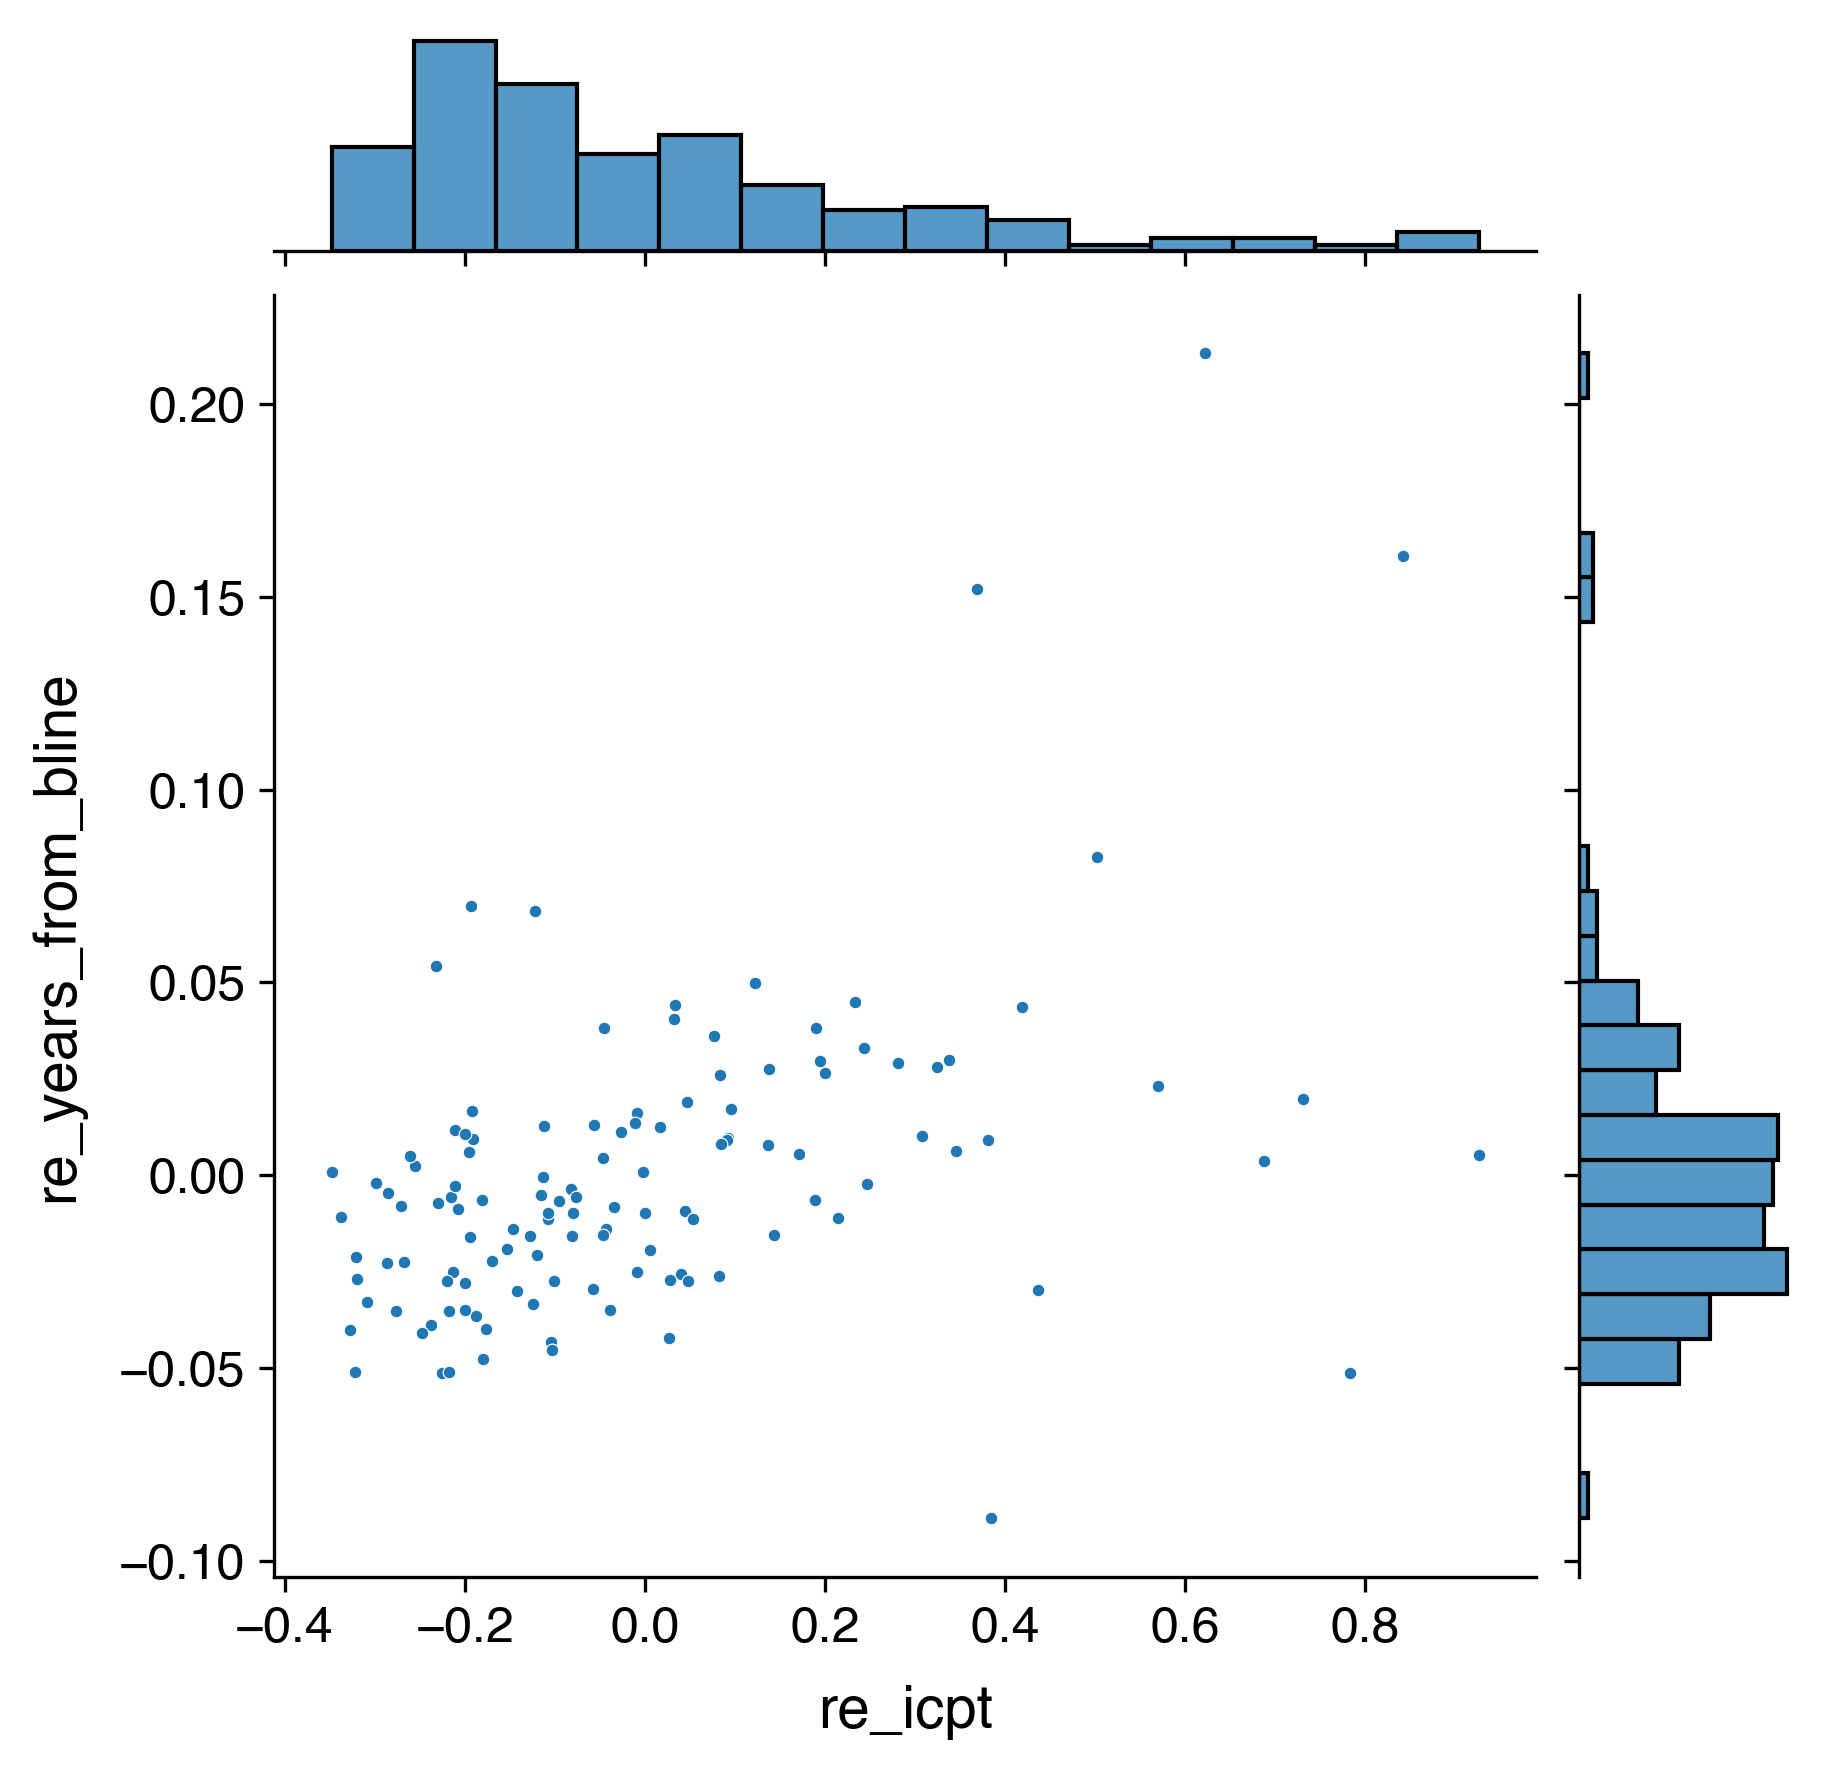

In [125]:
#tau_suvrs_mem["scaled_slope"] = tau_suvrs_mem["fe_icpt"] + tau_suvrs_mem["re_icpt"] + (tau_suvrs_mem["years_from_bline"] * tau_suvrs_mem["re_years_from_bline"])
np.allclose(tau_suvrs_mem["pred"], tau_suvrs_mem["fe_icpt"] + (tau_suvrs_mem["years_from_bline"] * tau_suvrs_mem["fe_years_from_bline"]) + tau_suvrs_mem["re_icpt"] + (tau_suvrs_mem["years_from_bline"] * tau_suvrs_mem["re_years_from_bline"]))
sns.jointplot(dat_pred, x="re_icpt", y="re_years_from_bline")

In [48]:
tau_suvrs["roi"].value_counts().sort_index()

acc      448
dlpfc    448
ins      448
ipc      448
itc      448
mtc      448
mtl      448
occ      448
pcc      448
pcu      448
smc      448
spc      448
stc      448
v1       448
vlpfc    448
vmpfc    448
Name: roi, dtype: int64

<>:42: DeprecationWarning: invalid escape sequence '\c'
<>:78: DeprecationWarning: invalid escape sequence '\c'
<>:42: DeprecationWarning: invalid escape sequence '\c'
<>:78: DeprecationWarning: invalid escape sequence '\c'
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_35046/539245672.py:42: DeprecationWarning: invalid escape sequence '\c'
  linewidth=lw/3, marker="$\circ$", ec="face")
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_35046/539245672.py:78: DeprecationWarning: invalid escape sequence '\c'
  linewidth=lw/3, marker="$\circ$", ec="face")
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_35046/539245672.py:49: UserWarning: 
The palette list has fewer values (1) than needed (126) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x=xcol, y="value", data=dat, ax=_ax,


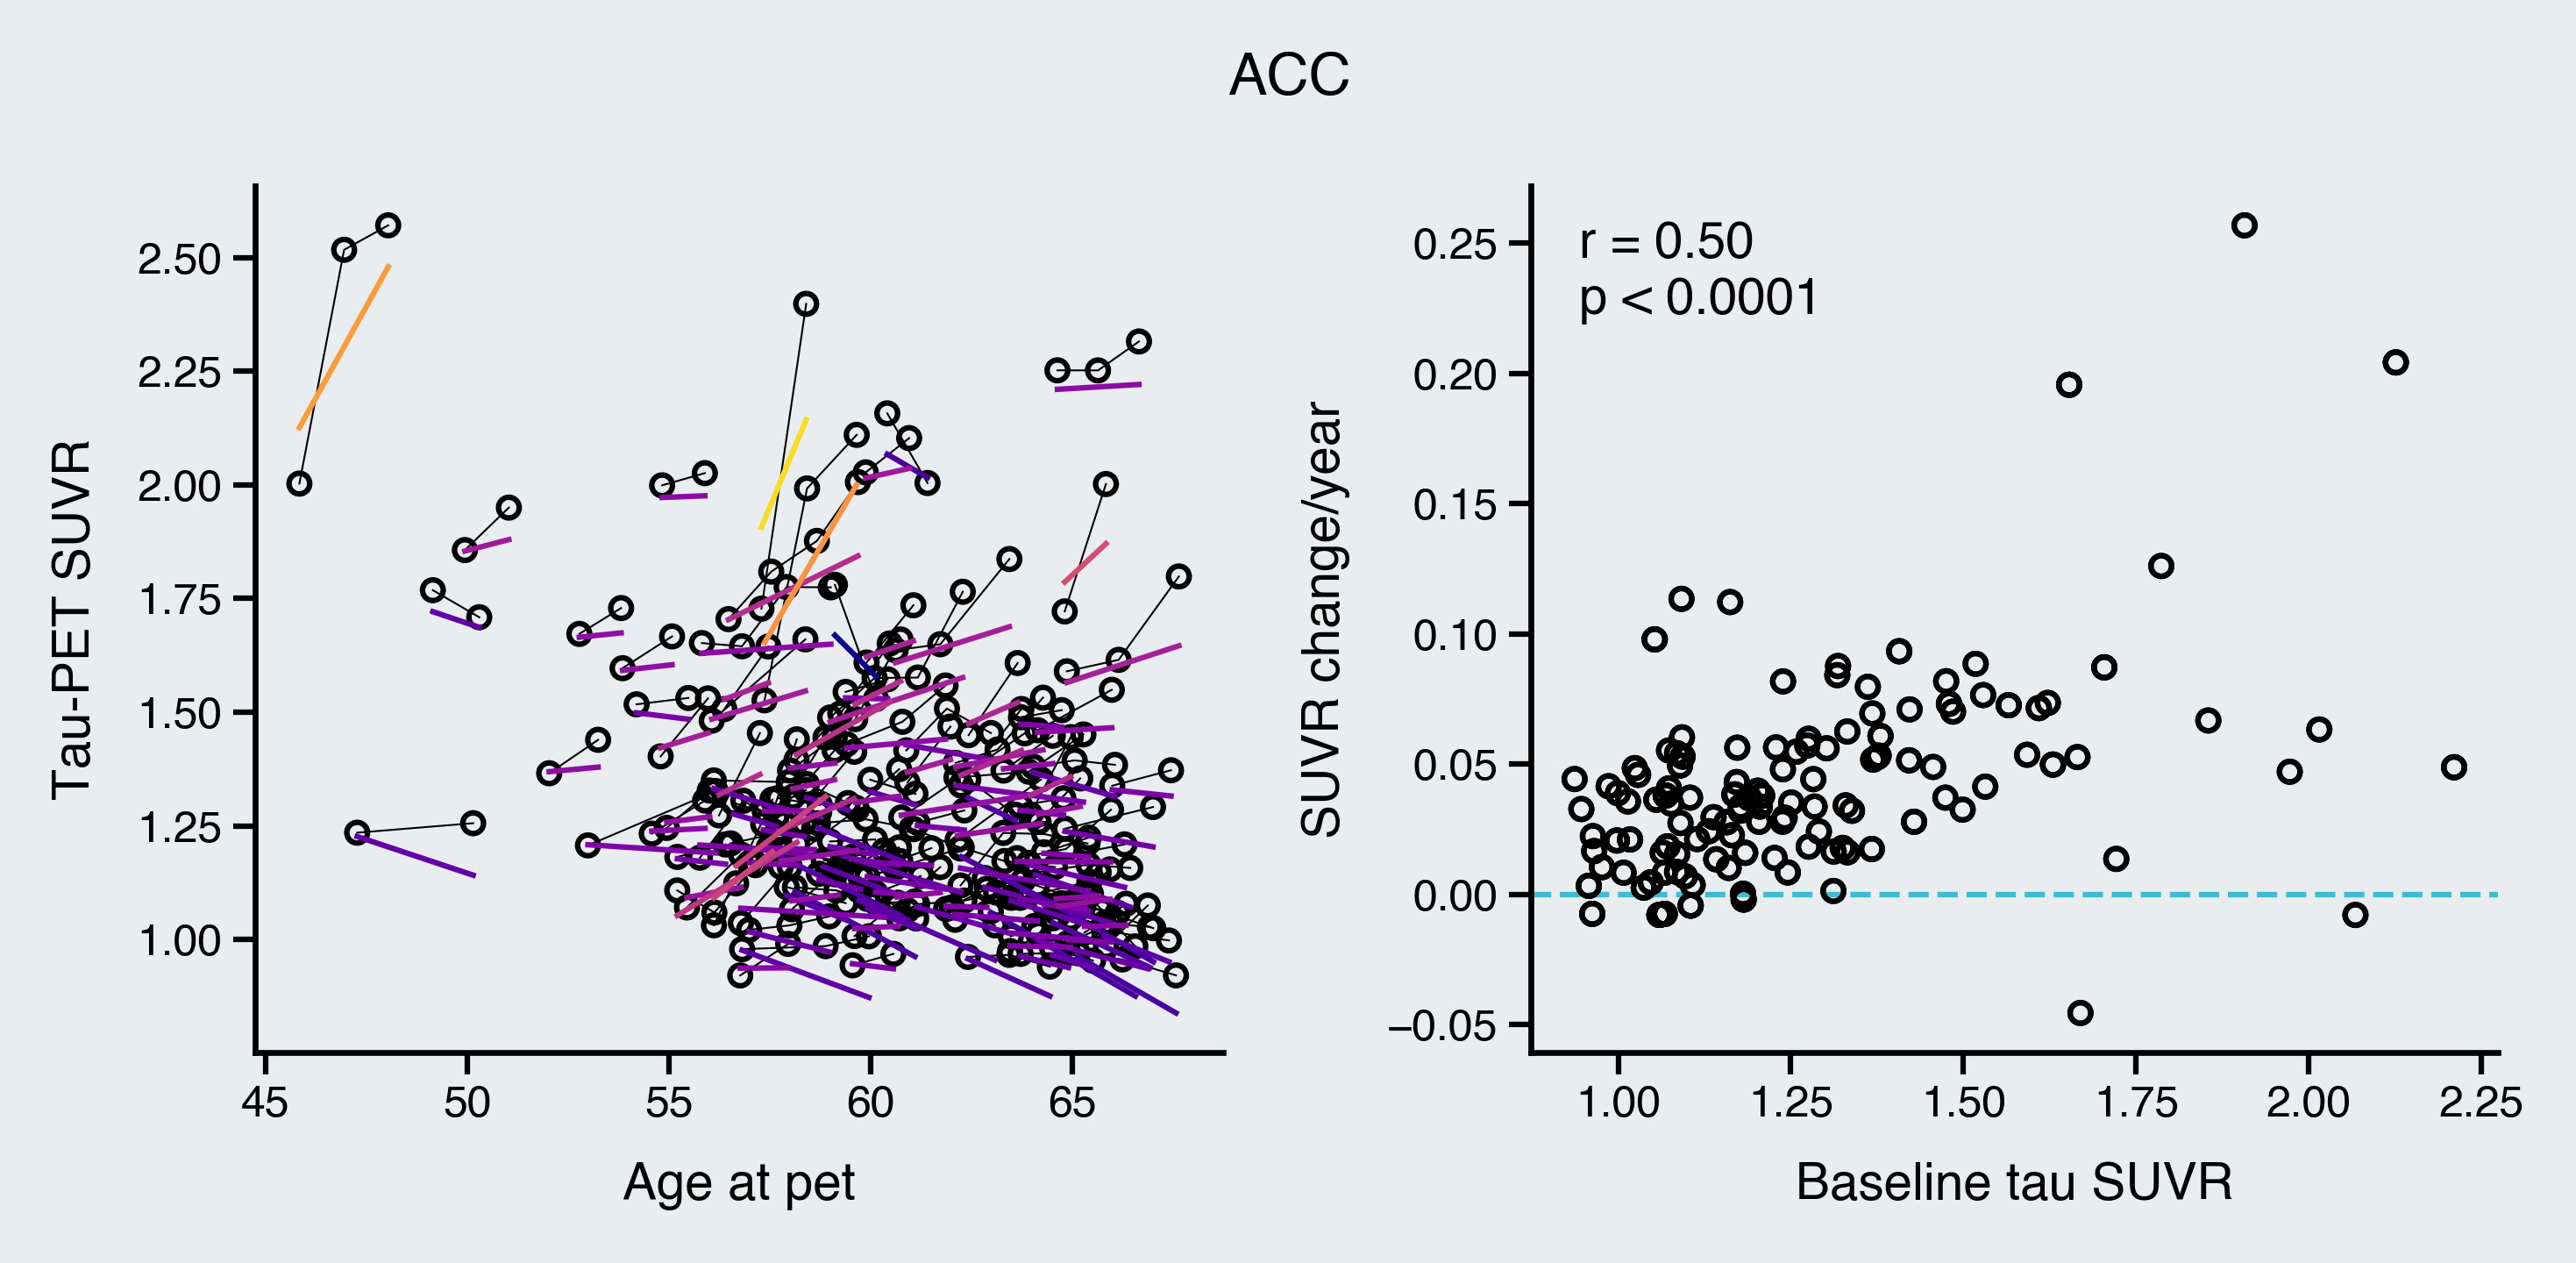

In [116]:
roi = "acc" #"R_rostralanteriorcingulate" #"L_caudalmiddlefrontal" 
n_pet_visits = 2
scatter_size = 24
figsize = (5, 5*0.5)
dpi = 600
font = {"tick": 6, "label": 7, "title": 8, "annot": 7}
tickpad = 1.5
ticklen = 3
labelpad = 5
lw = 0.75
palette = "plasma"
bg_color = co["x1"]
show_timepoint_connections = True
colorize_points_by_subj = False
colorize_points_by_n_visits = False
xcol = "age_at_pet"

# ----------------------------------------------------------------------
# Select data for the given ROI.
keep_cols = ["subj", "visit", "pet_visits", "roi", "value",
             "years_from_bline", "age_at_pet", "cdrsb_bline", "mmse_baseline", "fbb_centiloids_baseline",]
dat = tau_suvrs.query("(roi=='{}') & (pet_visits>={})".format(roi, n_pet_visits))[keep_cols].copy()
dat["fbb_centiloids_baseline"] = dat["fbb_centiloids_baseline"].astype(float)
dat_pred = tau_suvrs_mem.query("(roi=='{}') & (pet_visits>={})".format(roi, n_pet_visits)).copy()
dat_pred["pet_visits_gt2"] = dat_pred["pet_visits"] > 2
min_slope = dat_pred["re_years_from_bline"].min()
max_slope = dat_pred["re_years_from_bline"].max()

# Make a scatterplot of the data.
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

# ----------------------------------------------------------------------
iax = 0
_ax = ax[iax]

# Add a point for each SUVR value.
if colorize_points_by_subj:
    sns.scatterplot(x=xcol, y="value", data=dat,
                    hue="subj", palette=palettes["economist"],
                    s=scatter_size, legend=False, ax=_ax,
                    linewidth=lw/3, marker="$\circ$", ec="face")
else:
    _ax.scatter(x=dat[xcol], y=dat["value"], s=scatter_size/3,
                facecolors="none", edgecolors="k", linewidths=lw)

# Add a line connecting values from each subject over time.
if show_timepoint_connections:
    sns.lineplot(x=xcol, y="value", data=dat, ax=_ax,
                 hue="subj", palette=["k"], lw=lw/3, legend=False, zorder=0)

# Add a line for each subject showing the model-predicted values.
sns.lineplot(x=xcol, y="scaled_slope", data=dat_pred,
             units="subj", hue="re_years_from_bline", hue_norm=(min_slope, max_slope*1.1),
             palette=palette, lw=lw, legend=False, ax=_ax)

# Label axes.
_ax.set_xlabel(xcol.replace("_", " ").capitalize(), fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("Tau-PET SUVR", fontsize=font["label"], labelpad=labelpad)

# Set the legend limits.
max_slope = np.abs(dat_pred["re_years_from_bline"].max())

# Control the hue limits.
_ax.collections[0].set_clim(-max_slope, max_slope)

# ----------------------------------------------------------------------
iax = 1
_ax = ax[iax]
xlim = (2, 7.2)
xticks = [2, 3, 4, 5, 6, 7]
ylim = (-0.2, 0.6)
yticks = [-0.2, 0, 0.2, 0.4, 0.6]
if colorize_points_by_n_visits:
    sns.scatterplot(x="md_icpt", y="md_years_from_bline", data=dat_pred,
                    hue="pet_visits_gt2", palette=[co["b"], co["m"]],
                    s=scatter_size, legend=True, ax=_ax,
                    linewidth=lw/3, marker="$\circ$", ec="face")
else:
    _ax.scatter(x=dat_pred["md_icpt"], y=dat_pred["md_years_from_bline"], s=scatter_size/3,
                facecolors="none", edgecolors="k", linewidths=lw)
    
# Add the Pearson correlation as a text annotation.
r, p = stats.pearsonr(dat_pred["md_icpt"], dat_pred["md_years_from_bline"])
if p < 0.0001:
    msg = "r = {:.2f}\np < 0.0001".format(r)
else:
    msg = "r = {:.2f}\np = {:.4f}".format(r, p)
_ax.text(0.05, 0.9, msg,
         transform=_ax.transAxes, ha="left", va="center",
         fontsize=font["annot"], color=co["k"])
    
# Draw a horizontal dashed line through 0
_ax.axhline(0, ls="--", lw=lw, color=co["c"], zorder=0)

# _ax.set_xlim(xlim)
# _ax.set_ylim(ylim)
# _ax.set_xticks(xticks)
# _ax.set_yticks(yticks)
_ax.set_xlabel("Baseline tau SUVR", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("SUVR change/year", fontsize=font["label"], labelpad=labelpad)

if colorize_points_by_n_visits:
    leg = _ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.95, 0.95),
        fontsize=font["tick"],
        # labels=["2 visits", "3+ visits"],
        borderpad=0,
        handletextpad=0,
        title="3+ scans",
        title_fontsize=font["tick"],
    )

# ----------------------------
for _ax in ax:
    _ax.tick_params(labelsize=font["tick"], length=ticklen, width=lw, pad=tickpad)
    _ax.set_facecolor(bg_color)
    _ax.grid(False)

fig.suptitle("{}".format(roi).replace("_", " ").upper(), fontsize=font["title"], y=0.94)
fig.patch.set_facecolor(bg_color)
fig.tight_layout()
plt.show()

<>:38: DeprecationWarning: invalid escape sequence '\c'
<>:75: DeprecationWarning: invalid escape sequence '\c'
<>:38: DeprecationWarning: invalid escape sequence '\c'
<>:75: DeprecationWarning: invalid escape sequence '\c'
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_46032/1024920900.py:38: DeprecationWarning: invalid escape sequence '\c'
  linewidth=lw/3, marker="$\circ$", ec="face")
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_46032/1024920900.py:75: DeprecationWarning: invalid escape sequence '\c'
  linewidth=lw/3, marker="$\circ$", ec="face")
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_46032/1024920900.py:45: UserWarning: 
The palette list has fewer values (1) than needed (126) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="age_at_pet", y="value", data=dat, ax=_ax,


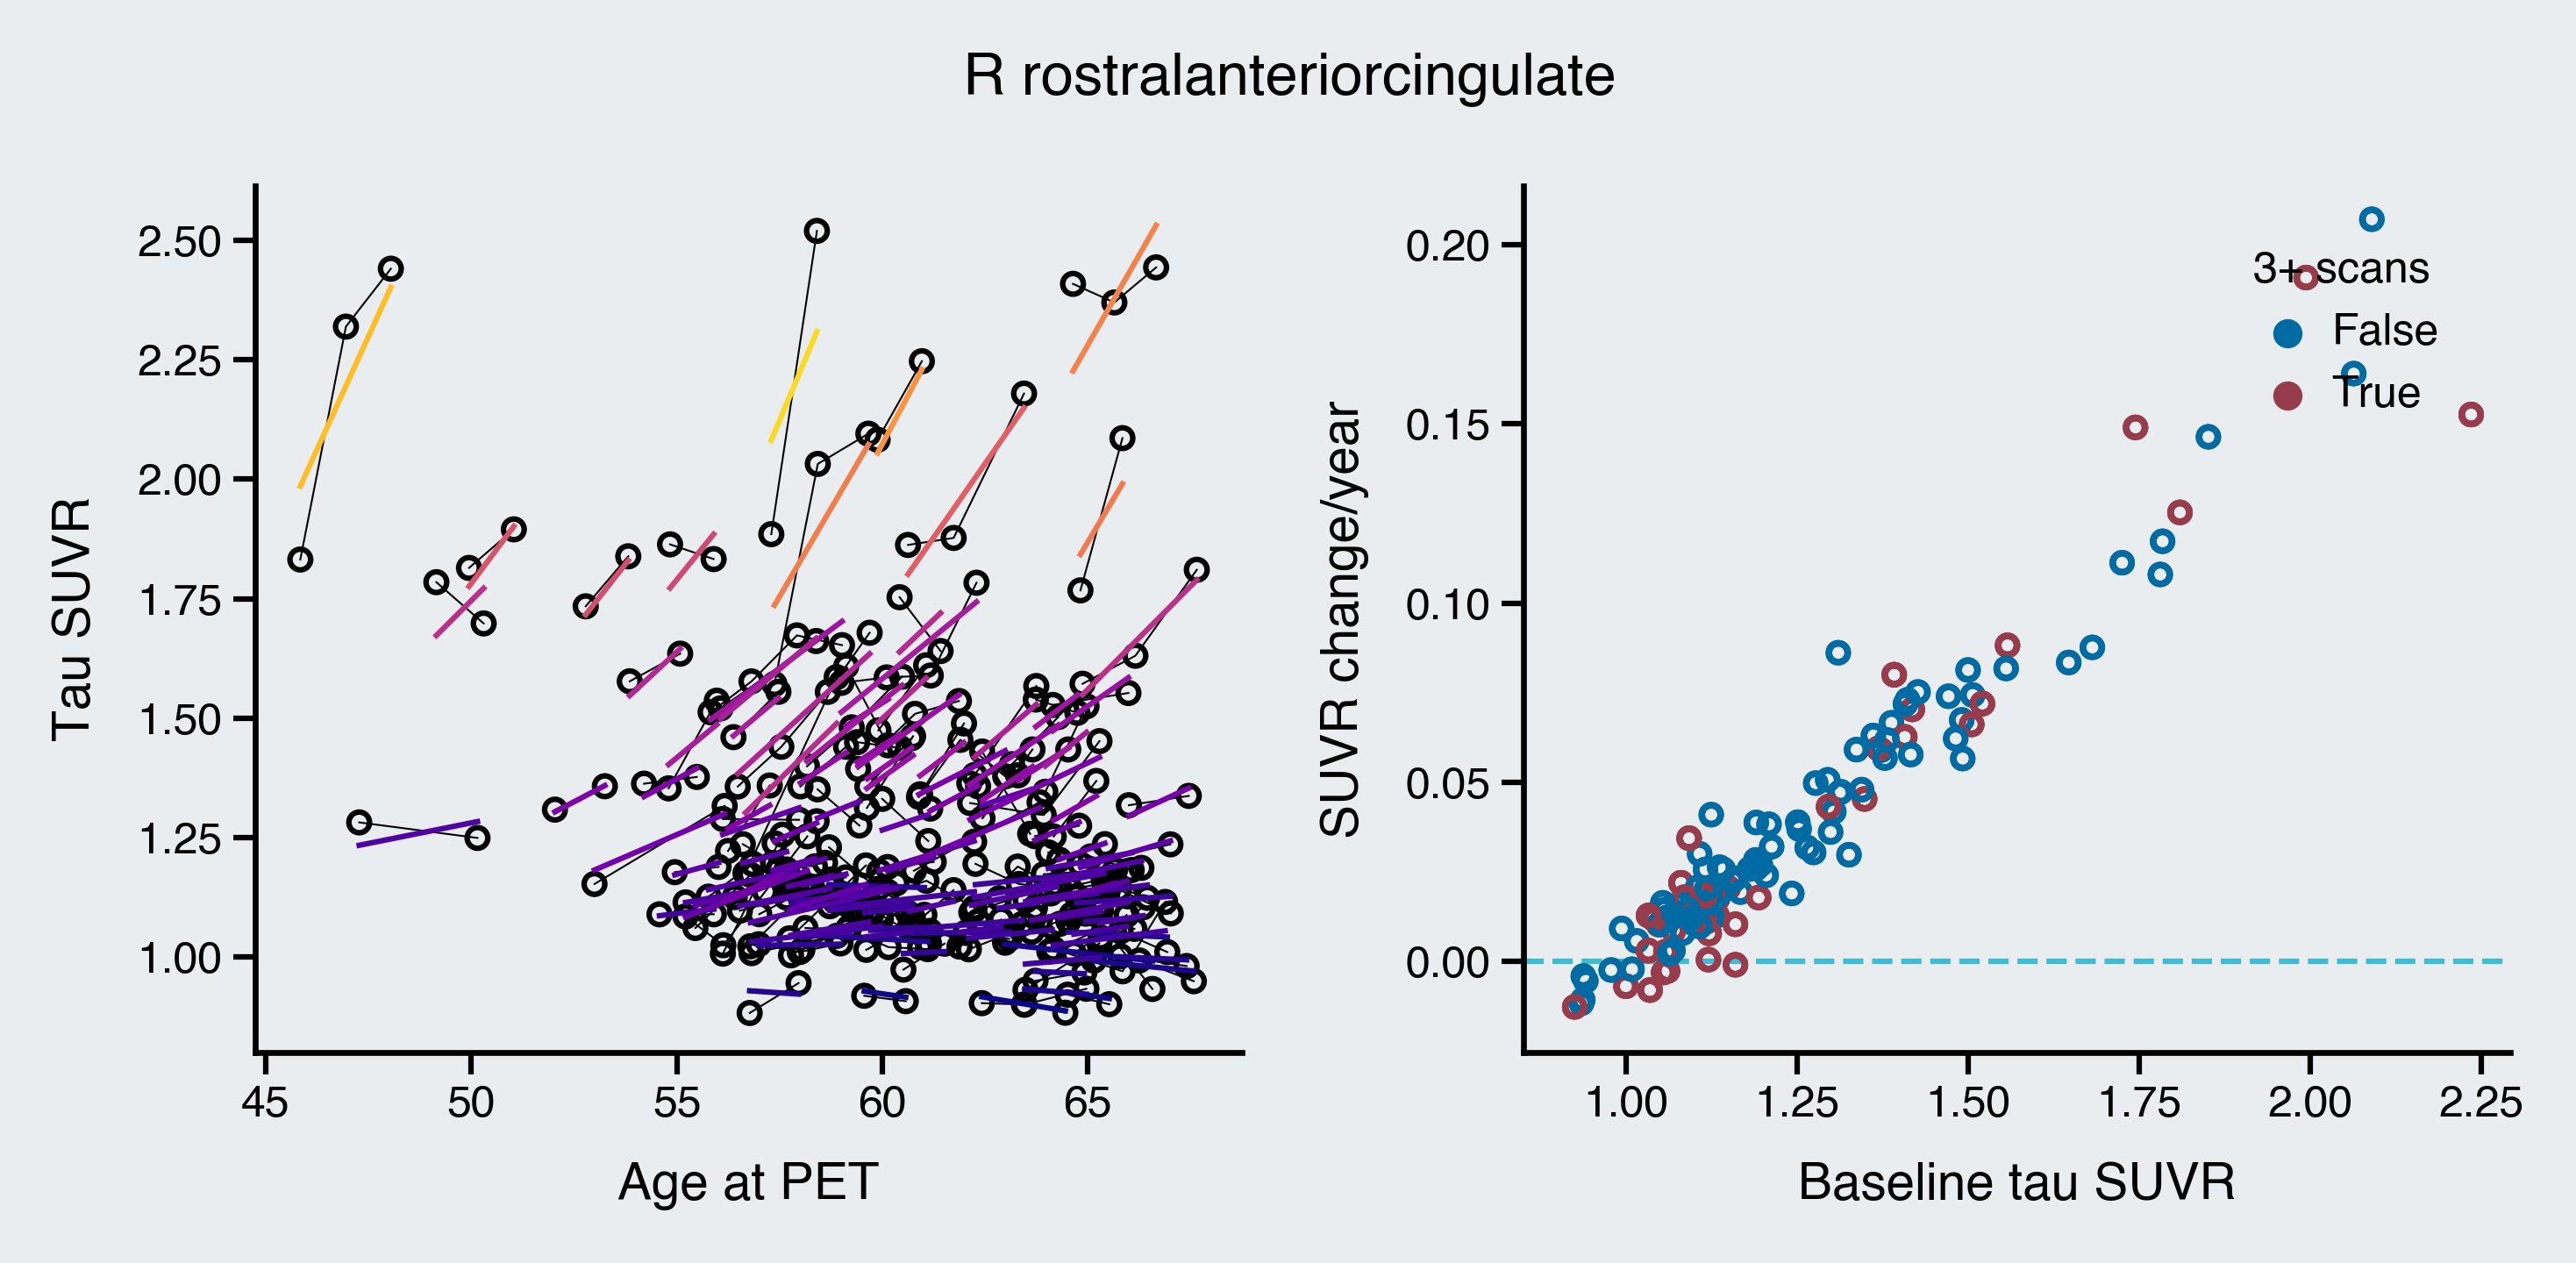

In [390]:
roi = "R_rostralanteriorcingulate" #"L_caudalmiddlefrontal" "L_inferiorparietal"
n_pet_visits = 2
scatter_size = 24
figsize = (5, 5*0.5)
dpi = 600
font = {"tick": 6, "label": 7, "title": 8, "annot": 6}
tickpad = 1.5
ticklen = 3
labelpad = 5
lw = 0.75
palette = "plasma"
bg_color = co["x1"]
show_timepoint_connections = True
colorize_points_by_subj = False
colorize_points_by_n_visits = True

# ----------------------------------------------------------------------
# Select data for the given ROI.
keep_cols = ["subj", "age_at_pet", "visit", "pet_visits", "roi", "value"]
dat = tau_suvrs.query("(roi=='{}') & (pet_visits>={})".format(roi, n_pet_visits))[keep_cols]
dat_pred = tau_suvrs_mem.query("(roi=='{}') & (pet_visits>={})".format(roi, n_pet_visits)).copy()
dat_pred["pet_visits_gt2"] = dat_pred["pet_visits"] > 2
min_slope = dat_pred["re_years_from_bline"].min()
max_slope = dat_pred["re_years_from_bline"].max()

# Make a scatterplot of the data.
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

# ----------------------------------------------------------------------
iax = 0
_ax = ax[iax]
# Add a point for each SUVR value.
if colorize_points_by_subj:
    sns.scatterplot(x="age_at_pet", y="value", data=dat,
                    hue="subj", palette=palettes["economist"],
                    s=scatter_size, legend=False, ax=_ax,
                    linewidth=lw/3, marker="$\circ$", ec="face")
else:
    _ax.scatter(x=dat["age_at_pet"], y=dat["value"], s=scatter_size/3,
                facecolors="none", edgecolors="k", linewidths=lw)

# Add a line connecting values from each subject over time.
if show_timepoint_connections:
    sns.lineplot(x="age_at_pet", y="value", data=dat, ax=_ax,
                 hue="subj", palette=["k"], lw=lw/3, legend=False, zorder=0)
sns.lineplot(x="age_at_pet", y="pred", data=dat_pred,
             units="subj", hue="re_years_from_bline", hue_norm=(min_slope, max_slope*1.1),
             palette=palette, lw=lw, legend=False, ax=_ax)
_ax.set_xlabel("Age at PET", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("Tau SUVR", fontsize=font["label"], labelpad=labelpad)

# Set the legend limits.
max_slope = np.abs(dat_pred["re_years_from_bline"].max())

# Control the hue limits.
_ax.collections[0].set_clim(-max_slope, max_slope)

# ----------------------------------------------------------------------
iax = 1
_ax = ax[iax]
xlim = (2, 7.2)
xticks = [2, 3, 4, 5, 6, 7]
ylim = (-0.2, 0.6)
yticks = [-0.2, 0, 0.2, 0.4, 0.6]
# Plot "mod_icpt" against "mod_years_from_bline"
# sns.scatterplot(x="md_years_from_bline", y="md_icpt", data=dat_pred,
#                 hue="subj", palette="tab20b",
#                 s=scatter_size, legend=False, ax=_ax,
#                 linewidths=lw, marker="$\circ$", ec="face")
if colorize_points_by_n_visits:
    sns.scatterplot(x="md_icpt", y="md_years_from_bline", data=dat_pred,
                    hue="pet_visits_gt2", palette=[co["b"], co["m"]],
                    s=scatter_size, legend=True, ax=_ax,
                    linewidth=lw/3, marker="$\circ$", ec="face")
else:
    _ax.scatter(x=dat_pred["md_icpt"], y=dat_pred["md_years_from_bline"], s=scatter_size/3,
                facecolors="none", edgecolors="k", linewidths=lw)
    
# Draw a horizontal dashed line through 0
_ax.axhline(0, ls="--", lw=lw, color=co["c"], zorder=0)

# _ax.set_xlim(xlim)
# _ax.set_ylim(ylim)
# _ax.set_xticks(xticks)
# _ax.set_yticks(yticks)
_ax.set_xlabel("Baseline tau SUVR", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("SUVR change/year", fontsize=font["label"], labelpad=labelpad)

if colorize_points_by_n_visits:
    leg = _ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.95, 0.95),
        fontsize=font["tick"],
        # labels=["2 visits", "3+ visits"],
        borderpad=0,
        handletextpad=0,
        title="3+ scans",
        title_fontsize=font["tick"],
    )

# ----------------------------
for _ax in ax:
    _ax.tick_params(labelsize=font["tick"], length=ticklen, width=lw, pad=tickpad)
    _ax.set_facecolor(bg_color)
    _ax.grid(False)

fig.suptitle("{}".format(hemroi).replace("_", " "), fontsize=font["title"], y=0.94)
fig.patch.set_facecolor(bg_color)
fig.tight_layout()
plt.show()

In [ ]:
# Load the input dataframe.
infile = op.join(data_dir, "ssheets", "tau_rois_eoad_longitudinal.csv")
tau_coefs = pd.read_csv(infile, index_col=0).reset_index(drop=True)
for col in ["subj", "hemroi", "hem", "roi"]:
    tau_coefs[col] = tau_coefs[col].astype(pd.CategoricalDtype(list(tau_coefs[col].unique()), ordered=True))

# Load subject demographic data.
infile = op.join(data_dir, "ssheets", "tau_rois.csv")
tau_subjs = pd.read_csv(infile, index_col=0)
keep_cols = ['subj', 'dx', 'sex_m', 'dob', 'age_at_pet', 'minority', 'apoe_genotype',
             'apoe4_alleles', 'cdrsob_baseline', 'mmse_baseline', 'visit',
             'fbb_date_baseline', 'fbb_centiloids_baseline', 'fbb_positive']
keep_subjs = list(tau_coefs["subj"].unique())
tau_subjs = tau_subjs.loc[:, keep_cols]
tau_subjs = tau_subjs.loc[tau_subjs["visit"]==1]
keep_idx = np.where(tau_subjs["subj"].apply(lambda x: x in keep_subjs))[0]
tau_subjs = tau_subjs.iloc[keep_idx, :].drop_duplicates().reset_index(drop=True)

print(f"tau_subjs: {tau_subjs.shape}")
print(f"tau_coefs: {tau_coefs.shape}")

tau_subjs: (126, 14)
tau_coefs: (9072, 6)


In [ ]:
tau_coefs.head()

subj      hemroi hem       roi      icpt     years
0  LDS0070166  L_amygdala   L  amygdala  3.711885  0.044636
1  LDS0070174  L_amygdala   L  amygdala  3.134835  0.088753
2  LDS0070199  L_amygdala   L  amygdala  3.631084  0.066495
3  LDS0070263  L_amygdala   L  amygdala  3.470215  0.091430
4  LDS0070302  L_amygdala   L  amygdala  3.987125 -0.024372

In [ ]:
tau_coefs.min(), tau_coefs.max()

(subj      LDS0070166
 hemroi    L_amygdala
 hem                L
 roi         amygdala
 icpt        2.141944
 years      -0.142236
 dtype: object,
 subj                LDS9410298
 hemroi    R_transversetemporal
 hem                          R
 roi         transversetemporal
 icpt                  7.019059
 years                 0.583834
 dtype: object)

In [ ]:
tau_subjs.columns

Index(['subj', 'dx', 'sex_m', 'dob', 'age_at_pet', 'minority', 'apoe_genotype',
       'apoe4_alleles', 'cdrsob_baseline', 'mmse_baseline', 'visit',
       'fbb_date_baseline', 'fbb_centiloids_baseline', 'fbb_positive'],
      dtype='object')

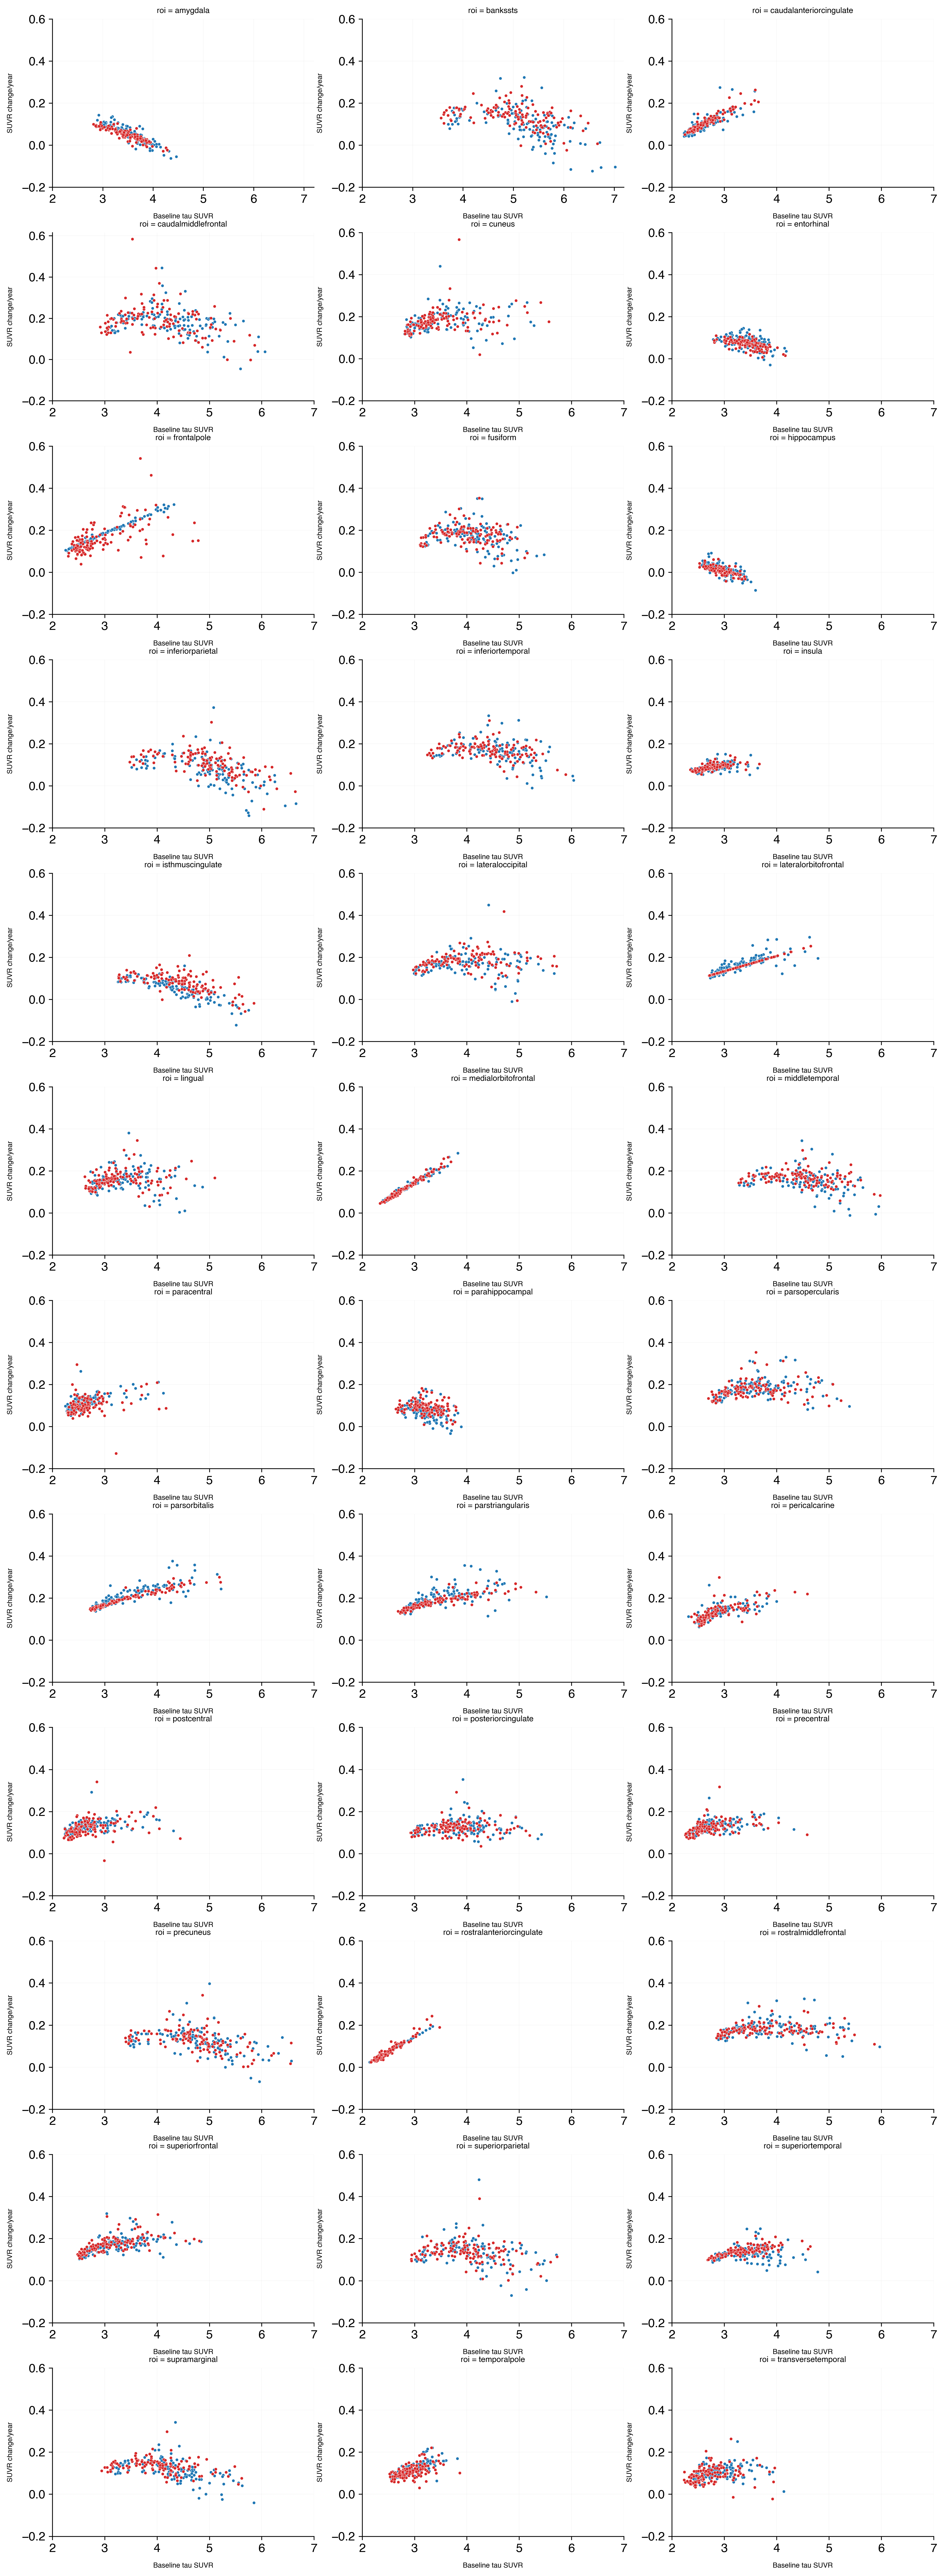

In [ ]:
# Create a scatterplot for every ROI in tau_coefs["roi"].unique().
# Graph icpt vs. years, and color by hem.
xlim = (2, 7.2)
xticks = [2, 3, 4, 5, 6, 7]
ylim = (-0.2, 0.6)
yticks = [-0.2, 0, 0.2, 0.4, 0.6]
font = {"tick": 6, "label": 7, "title": 8, "annot": 6}
tickpad = 1.5
labelpad = 3

# -----------------------------
plt.close("all")
g = sns.FacetGrid(tau_coefs, col="roi", hue="hem", col_wrap=3, height=3, aspect=1.5, sharex=False, sharey=False)
g.map(sns.scatterplot, "icpt", "years")

# Adjust the axes for each plot.
for iax, ax in enumerate(g.axes.flat):
    if iax == 0:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax.set_xlabel("Baseline tau SUVR", fontsize=font["label"])
    ax.set_ylabel("SUVR change/year", fontsize=font["label"])
    ax.set_title(ax.get_title(), fontsize=font["title"])
    # ax.tick_params(labelsize=font["tick"], labelpad=tickpad)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.grid(True, alpha=0.5)